In [1]:
import pandas as pd
import json
import requests
import matplotlib.pylab as plt

from itertools import groupby
from datetime import datetime as dt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
METRICS_ALL = 'accessors,new_technical_debt,blocker_violations,conditions_to_cover,new_it_conditions_to_cover,new_conditions_to_cover,bugs,burned_budget,business_value,class_complexity_distribution,classes,code_smells,comment_lines,commented_out_code_lines,comment_lines_density,comment_lines_data,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,branch_coverage,new_it_branch_coverage,new_branch_coverage,conditions_by_line,confirmed_issues,coverage,new_it_coverage,coverage_line_hits_data,new_coverage,covered_conditions_by_line,critical_violations,last_commit_date,directories,duplicated_blocks,new_duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,new_duplicated_lines,new_duplicated_lines_density,duplications_data,effort_to_reach_maintainability_rating_a,executable_lines_data,false_positive_issues,file_complexity_distribution,files,function_complexity_distribution,functions,generated_lines,generated_ncloc,info_violations,violations,it_conditions_to_cover,it_branch_coverage,it_conditions_by_line,it_coverage,it_coverage_line_hits_data,it_covered_conditions_by_line,it_line_coverage,it_lines_to_cover,it_uncovered_conditions,it_uncovered_lines,line_coverage,new_it_line_coverage,new_line_coverage,lines,ncloc,ncloc_language_distribution,new_lines,lines_to_cover,new_it_lines_to_cover,new_lines_to_cover,sqale_rating,new_maintainability_rating,major_violations,minor_violations,ncloc_data,new_blocker_violations,new_bugs,new_code_smells,new_critical_violations,new_info_violations,new_violations,new_major_violations,new_minor_violations,new_vulnerabilities,open_issues,overall_conditions_to_cover,new_overall_conditions_to_cover,overall_branch_coverage,new_overall_branch_coverage,overall_conditions_by_line,overall_coverage,overall_coverage_line_hits_data,new_overall_coverage,overall_covered_conditions_by_line,overall_line_coverage,new_overall_line_coverage,overall_lines_to_cover,new_overall_lines_to_cover,overall_uncovered_conditions,new_overall_uncovered_conditions,overall_uncovered_lines,new_overall_uncovered_lines,quality_profiles,projects,public_api,public_documented_api_density,public_undocumented_api,quality_gate_details,alert_status,reliability_rating,new_reliability_rating,reliability_remediation_effort,new_reliability_remediation_effort,reopened_issues,security_rating,new_security_rating,security_remediation_effort,new_security_remediation_effort,skipped_tests,development_cost,statements,team_size,sqale_index,sqale_debt_ratio,new_sqale_debt_ratio,uncovered_conditions,new_it_uncovered_conditions,new_uncovered_conditions,uncovered_lines,new_it_uncovered_lines,new_uncovered_lines,test_data,test_execution_time,test_errors,test_failures,test_success_density,tests,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,file_complexity_distribution,files,function_complexity_distribution,functions,info_violations,violations,lines,ncloc,ncloc_language_distribution,sqale_rating,major_violations,minor_violations,open_issues,quality_profiles,quality_gate_details,alert_status,reliability_rating,reliability_remediation_effort,reopened_issues,security_rating,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL_NOTSTRING = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,files,functions,info_violations,violations,lines,ncloc,major_violations,minor_violations,open_issues,reliability_remediation_effort,reopened_issues,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL_NOTSTRING_NOTLASTITEMVALUE = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,files,functions,info_violations,violations,lines,ncloc,major_violations,minor_violations,open_issues,reliability_remediation_effort,reopened_issues,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_MTD = 'code_smells,bugs,classes,lines,ncloc,sqale_index,violations,blocker_violations,critical_violations,major_violations,minor_violations'
METRICS = METRICS_MTD
METRICS_LIST = METRICS.split(',')
metrics_list_length = len(METRICS_LIST)

# Classes

In [4]:
HETZNER_IP = '176.9.137.234'
UOM_PC_IP = '195.251.210.136'
UOM_DB_IP = '195.251.210.166'
RUG_IP = '129.125.5.170'
MACBOOK_IP = '145.97.138.131'
SONARQUBE_IP = HETZNER_IP

SONARQUBE_PORT = '9000'
REST_API_PORT = '8080'

COMMIT_STATS_API_URL = '/GitHubCommitStatsRest/webresources/commitstatsfiles/repo/'
COMMIT_STATS_API_CACHE_URL = '/GitHubCommitStatsCache/webresources/commitsstats/json/'
COMMIT_STATS_FILES_API_URL = '/api/commitStatsFiles'
COMMIT_STATS_FILES_PER_REPO_API_URL = COMMIT_STATS_FILES_API_URL + '/repo/'
REST_URL = COMMIT_STATS_FILES_PER_REPO_API_URL

PROTOCOL = 'http://'

class GitHubProject:
    def __init__(self, repo_id, owner, repo, language, sonarqube_ip=SONARQUBE_IP, rest_api_ip = UOM_DB_IP):
        self.repo_id = repo_id
        self.owner = owner
        self.repo = repo
        self.language = language
        self.sonarqube_ip = sonarqube_ip
        self.rest_api_ip = rest_api_ip
        self.sonarqube_project_key = self.owner+':'+self.repo
        self.rest_key = self.owner+'/'+self.repo
        self.timemachine_metrics_url = PROTOCOL + self.sonarqube_ip + ':' + SONARQUBE_PORT + '/api/'+ 'timemachine?' + 'resource=' + self.sonarqube_project_key + '&metrics='
        self.commit_stats_url = PROTOCOL + self.rest_api_ip + ':' + REST_API_PORT + REST_URL + str(self.repo_id)

In [5]:
class CommitStatsFile:
    def __init__(self, fileName, additions, deletions, changes, status, commitDate):
        self.fileName = fileName
        self.additions = float(additions)
        self.deletions = float(deletions)
        self.changes = float(changes)
        self.status = status
        self.commitDate = commitDate


    def __repr__(self):
        return "<CommitStatsFile fileName:%s additions:%s deletions:%s changes:%s status:%s commitDate:%s>" % (self.fileName, self.additions, self.deletions, self.changes, self.status, self.commitDate)

    def __str__(self):
        return "From str method of CommitStatsFile: fileName:%s additions:%s deletions:%s changes:%s status:%s commitDate:%s>" % (self.fileName, self.additions, self.deletions, self.changes, self.status, self.commitDate)

# General functions

In [6]:
def get_rest_response(rest_url):
    response = requests.get(rest_url)
    return json.loads(response.text)

def jsonDate_to_date(date):
    return datetime.datetime.fromtimestamp(date / 1e3)

def get_date(date):
    return pd.Timestamp(date).date()

# Functions for getting SonarQube timemachine metrics

In [7]:
def get_repos():
    repos = []
    
    repos.append(GitHubProject(160994,'apache','sling','Java'))
    repos.append(GitHubProject(160999,'apache','zookeeper','Java'))
    repos.append(GitHubProject(205414,'apache','felix','Java'))
    repos.append(GitHubProject(206317,'apache','camel','Java'))
    
    repos.append(GitHubProject(892275,'square','retrofit','Java',sonarqube_ip='145.97.138.131'))
    repos.append(GitHubProject(1553754,'eclipse','orion.server','Java',sonarqube_ip='145.97.138.131'))
    repos.append(GitHubProject(1936771,'google','truth','Java',sonarqube_ip='145.97.138.131'))
    repos.append(GitHubProject(5152285,'square','okhttp','Java',sonarqube_ip='145.97.138.131'))
    repos.append(GitHubProject(7508411,'ReactiveX','RxJava','Java',sonarqube_ip='145.97.138.131'))
    repos.append(GitHubProject(10230369,'google','auto','Java',sonarqube_ip='145.97.138.131'))
    
#     repos.append(GitHubProject(2740148,'apache','opennlp','Java',sonarqube_ip='129.125.5.41'))
#     repos.append(GitHubProject(32137005,'apache','openmeetings','Java',sonarqube_ip='129.125.5.41'))
    
#     repos.append(GitHubProject(55334027,'apache','tomcat85','Java'))
#     repos.append(GitHubProject(60115659,'eclipse','xtext-eclipse','Java'))
    
#     repos.append(GitHubProject(106310,'junit-team','junit4','Java'))
#     repos.append(GitHubProject(160994,'apache','sling','Java'))
#     repos.append(GitHubProject(160999,'apache','zookeeper','Java'))
#     repos.append(GitHubProject(205414,'apache','felix','Java'))
#     repos.append(GitHubProject(206317,'apache','camel','Java'))
#     repos.append(GitHubProject(206338,'apache','directory-shared','Java'))
#     repos.append(GitHubProject(206350,'apache','cayenne','Java'))
#     repos.append(GitHubProject(206357,'apache','pig','Java'))
#     repos.append(GitHubProject(206368,'apache','poi','Java'))
#     repos.append(GitHubProject(206378,'apache','commons-lang','Java'))
#     repos.append(GitHubProject(206387,'apache','activemq','Java'))
#     repos.append(GitHubProject(206402,'apache','httpclient','Java'))
#     repos.append(GitHubProject(206403,'apache','jackrabbit','Java'))
#     repos.append(GitHubProject(206412,'apache','wicket','Java'))
#     repos.append(GitHubProject(206424,'apache','cassandra','Java'))
#     repos.append(GitHubProject(206444,'apache','hive','Java'))
#     repos.append(GitHubProject(206483,'apache','maven','Java'))
#     repos.append(GitHubProject(230296,'apache','wss4j','Java'))
#     repos.append(GitHubProject(318103,'apache','pdfbox','Java'))
#     repos.append(GitHubProject(322018,'apache','aries','Java'))
#     repos.append(GitHubProject(460078,'angular','angular.js','JavaScript'))
#     repos.append(GitHubProject(507775,'elastic','elasticsearch','Java'))
#     repos.append(GitHubProject(605999,'twitter','flockdb','Scala'))
#     repos.append(GitHubProject(688352,'apache','jmeter','Java'))
#     repos.append(GitHubProject(732593,'cloudera','hue','Python'))
#     repos.append(GitHubProject(790031,'openstack','nova','Python'))
#     repos.append(GitHubProject(832681,'apache','tomcat70','Java'))
#     repos.append(GitHubProject(892275,'square','retrofit','Java'))
#     repos.append(GitHubProject(961036,'hibernate','hibernate-orm','Java'))
#     repos.append(GitHubProject(972205,'hibernate','hibernate-validator','Java'))
#     repos.append(GitHubProject(990281,'hibernate','hibernate-search','Java'))
#     repos.append(GitHubProject(1020639,'Pylons','pyramid','Python'))
#     repos.append(GitHubProject(1064563,'netty','netty','Java'))
#     repos.append(GitHubProject(1148753,'spring-projects','spring-framework','Java'))
#     repos.append(GitHubProject(1446467,'pypa','pip','Python'))
#     repos.append(GitHubProject(1463755,'spring-projects','spring-amqp-samples','Java'))
#     repos.append(GitHubProject(1553754,'eclipse','orion.server','Java'))
#     repos.append(GitHubProject(1553787,'eclipse','egit','Java'))
#     repos.append(GitHubProject(1553790,'eclipse','jgit','Java'))
#     repos.append(GitHubProject(1553793,'eclipse','linuxtools','Java'))
#     repos.append(GitHubProject(1608936,'hibernate','hibernate-ogm','Java'))
#     repos.append(GitHubProject(1936771,'google','truth','Java'))
#     repos.append(GitHubProject(1937202,'gitblit','gitblit','Java'))
#     repos.append(GitHubProject(2049379,'Netflix','curator','Java'))
#     repos.append(GitHubProject(2108481,'spring-projects','spring-security-oauth','Java'))
#     repos.append(GitHubProject(2153096,'apache','sqoop','Java'))
#     repos.append(GitHubProject(2198510,'apache','flume','Java'))
#     repos.append(GitHubProject(2211243,'apache','kafka','Java'))
#     repos.append(GitHubProject(2282376,'apache','giraph','Java'))
#     repos.append(GitHubProject(2304277,'spring-projects','spring-roo','Java'))
#     repos.append(GitHubProject(2340549,'playframework','playframework','Scala'))
#     repos.append(GitHubProject(2383782,'apache','oozie','Java'))
#     repos.append(GitHubProject(2442457,'apache','ambari','Java'))
#     repos.append(GitHubProject(2493904,'apache','tomcat','Java'))
#     repos.append(GitHubProject(2524488,'apache','accumulo','Java'))
#     repos.append(GitHubProject(2740148,'apache','opennlp','Java'))
#     repos.append(GitHubProject(2888818,'scala','scala','Scala'))
#     repos.append(GitHubProject(3604630,'eclipse','org.aspectj','Java'))
#     repos.append(GitHubProject(4164482,'django','django','Python'))
#     repos.append(GitHubProject(4368712,'jersey','jersey','Java'))
#     repos.append(GitHubProject(4416959,'apache','tapestry-5','Java'))
#     repos.append(GitHubProject(5152285,'square','okhttp','Java'))
#     repos.append(GitHubProject(5212656,'apache','odftoolkit','Java'))
#     repos.append(GitHubProject(5683653,'apache','drill','Java'))
#     repos.append(GitHubProject(5970647,'eclipse','dltk.core','Java'))
#     repos.append(GitHubProject(6207167,'mockito','mockito','Java'))
#     repos.append(GitHubProject(6235174,'conda','conda','Python'))
#     repos.append(GitHubProject(6296790,'spring-projects','spring-boot','Java'))
#     repos.append(GitHubProject(6766558,'Netflix','Hystrix','Java'))
#     repos.append(GitHubProject(6898381,'apache','cordova-android','Java'))
#     repos.append(GitHubProject(6929734,'openstack','cinder','Python'))
#     repos.append(GitHubProject(7053637,'python','mypy','Python'))
#     repos.append(GitHubProject(7437073,'apache','jena','Java'))
#     repos.append(GitHubProject(7508411,'ReactiveX','RxJava','Java'))
#     repos.append(GitHubProject(7691631,'docker','docker','Go'))
#     repos.append(GitHubProject(7748336,'apache','tomee','Java'))
#     repos.append(GitHubProject(9290699,'apache','tez','Java'))
#     repos.append(GitHubProject(9759448,'apache','cloudstack','Java'))
#     repos.append(GitHubProject(10230369,'google','auto','Java'))
#     repos.append(GitHubProject(10270250,'facebook','react','JavaScript'))
#     repos.append(GitHubProject(10616263,'apache','sis','Java'))
#     repos.append(GitHubProject(10637896,'apache','logging-log4j2','Java'))
#     repos.append(GitHubProject(11543457,'apache','falcon','Java'))
#     repos.append(GitHubProject(12169108,'google','closure-library','JavaScript'))
#     repos.append(GitHubProject(13414105,'python','peps','Python'))
#     repos.append(GitHubProject(13968333,'openstack','solum','Python'))
#     repos.append(GitHubProject(14135467,'apache','aurora','Java'))
#     repos.append(GitHubProject(14135470,'apache','storm','Java'))
#     repos.append(GitHubProject(15062869,'facebook','jest','JavaScript'))
#     repos.append(GitHubProject(15698466,'apache','jclouds','Java'))
#     repos.append(GitHubProject(15928650,'apache','struts','Java'))
#     repos.append(GitHubProject(16389681,'google','j2objc','Java'))
#     repos.append(GitHubProject(16977479,'apache','cxf','Java'))
#     repos.append(GitHubProject(17165658,'apache','spark','Scala'))
#     repos.append(GitHubProject(18845024,'google','closure-compiler','Java'))
#     repos.append(GitHubProject(19821157,'eclipse','birt','Java'))
#     repos.append(GitHubProject(20089857,'apache','hbase','Java'))
#     repos.append(GitHubProject(20300177,'google','guava','Java'))
#     repos.append(GitHubProject(20473418,'apache','phoenix','Java'))
#     repos.append(GitHubProject(20587599,'apache','flink','Java'))
#     repos.append(GitHubProject(21193524,'apache','calcite','Java'))
#     repos.append(GitHubProject(23418517,'apache','hadoop','Java'))
#     repos.append(GitHubProject(25623942,'apache','syncope','Java'))
#     repos.append(GitHubProject(26389457,'apache','tomcat80','Java'))
#     repos.append(GitHubProject(26525416,'apache','lens','Java'))
#     repos.append(GitHubProject(27911088,'apache','nifi','Java'))
#     repos.append(GitHubProject(29028775,'facebook','react-native','JavaScript'))
#     repos.append(GitHubProject(29102367,'junit-team','junit5','Java'))
#     repos.append(GitHubProject(30449481,'apache','tinkerpop','Java'))
#     repos.append(GitHubProject(31006158,'apache','ignite','Java'))
#     repos.append(GitHubProject(31524768,'facebook','nuclide','JavaScript'))
#     repos.append(GitHubProject(31976266,'apache','asterixdb','Java'))
#     repos.append(GitHubProject(32137005,'apache','openmeetings','Java'))
#     repos.append(GitHubProject(32805981,'eclipse','gyrex','Java'))
#     repos.append(GitHubProject(32848140,'apache','zeppelin','Java'))
#     repos.append(GitHubProject(32935745,'eclipse','che','Java'))
#     repos.append(GitHubProject(33024207,'apache','polygene-java','Java'))
#     repos.append(GitHubProject(34039690,'apache','groovy','Java'))
#     repos.append(GitHubProject(34839383,'apache','geode','Java'))
#     repos.append(GitHubProject(40508605,'facebook','relay','JavaScript'))
#     repos.append(GitHubProject(41348333,'apache','apex-core','Java'))
#     repos.append(GitHubProject(41348334,'apache','apex-malhar','Java'))
#     repos.append(GitHubProject(45896813,'apache','incubator-systemml','Java'))
#     repos.append(GitHubProject(47246081,'apache','brooklyn-server','Java'))
#     repos.append(GitHubProject(50229487,'apache','lucene-solr','Java'))
#     repos.append(GitHubProject(50904245,'apache','beam','Java'))
#     repos.append(GitHubProject(51905353,'apache','arrow','Java'))
#     repos.append(GitHubProject(55334027,'apache','tomcat85','Java'))
#     repos.append(GitHubProject(60115659,'eclipse','xtext-eclipse','Java'))
#     repos.append(GitHubProject(62117818,'apache','incubator-carbondata','Java'))
#     repos.append(GitHubProject(68273151,'apache','incubator-hivemall','Java'))
#     repos.append(GitHubProject(76634121,'apache','qpid-proton-j','Java'))
#     repos.append(GitHubProject(78186814,'apache','incubator-weex','Java'))
    
    return repos

In [8]:
def get_sonarqube_timemachine_metrics_DataFrame(ghp):
    json_data = get_sonarqube_timemachine_metrics(ghp)
    cells = get_cells(json_data)
    return transform_timemachine_metrics_to_series(cells)

def get_sonarqube_timemachine_metrics(ghp):
    return get_rest_response(ghp.timemachine_metrics_url + METRICS)

def get_cells(json_data):
    return json_data[0]['cells']  # cells - metric values

def get_colls(json_data):
    return json_data[0]['cols']  # cols - Metrcs

def get_no_of_versions(cells):
    return len(cells)

def transform_timemachine_metrics_to_series(cells):
    date_range_index = get_date_range_index_for_timemachine_metrics(cells)
    df = pd.DataFrame(index=date_range_index)
    for metric_index in range(0, metrics_list_length):
        s = pd.Series(index=date_range_index)
        for item in cells:
            s[pd.Timestamp(item.get('d')).date()] = item.get('v')[metric_index]
        df[METRICS_LIST[metric_index]] = s
    return df


def get_date_range_index_for_timemachine_metrics(cells):
    project_dates = get_project_dates(cells)
    min_project_date = min(project_dates)
    max_project_date = max(project_dates)
    return pd.date_range(start=min_project_date.date(), end=max_project_date.date(), freq='D')

def get_project_dates(cells):
    dates = []
    for item in cells:
        dates.append(pd.Timestamp(item.get('d')))
    return dates

# Functions for getting CommitStats

In [9]:
def get_commitfiles_stats_DataFrame(ghp):
    commit_files_stats_response = get_commit_files_stats_response(ghp)
    commitStatsFilesList = getCommitStatsFilesList(commit_files_stats_response)

    min_project_date = get_min_date(commit_files_stats_response)
    max_project_date = get_max_date(commit_files_stats_response)

    date_range_index = get_date_range_index(min_project_date, max_project_date)
    df = pd.DataFrame(index=date_range_index)
    groups = groupby(commitStatsFilesList, lambda csf: (get_date(csf.commitDate)))

    files_added = pd.Series(index=date_range_index)
    modified = pd.Series(index=date_range_index)
    removed = pd.Series(index=date_range_index)
    renamed = pd.Series(index=date_range_index)
    additions = pd.Series(index=date_range_index)
    deletions = pd.Series(index=date_range_index)
    changes = pd.Series(index=date_range_index)

    for key, group in groups:
        grp = list(group)

        files_added[key] = 0
        modified[key] = 0
        removed[key] = 0
        renamed[key] = 0
        additions[key] = 0
        deletions[key] = 0
        changes[key] = 0
        for item in grp:
            if (endswith(item.fileName, '.'+ghp.language)):
                if(item.status == 'added'):
                    files_added[key] += 1
                elif(item.status == 'modified'):
                    modified[key] += item.changes

                    additions[key] += item.additions
                    deletions[key] += item.deletions
                    changes[key] += item.changes
                elif(item.status == 'removed'):
                    removed[key] += item.deletions
                elif(item.status == 'renamed'):
                    renamed[key] += item.changes

    df['files_added'] = files_added
    df['additions'] = additions
    df['deletions'] = deletions
    df['changes'] = changes
    df['modified'] = modified
    df['removed'] = removed
    df['renamed'] = renamed

    return df

def get_commit_files_stats_response(ghp):
    return get_rest_response(ghp.commit_stats_url)

def getCommitStatsFilesList(commit_files_stats):
    commitStatsFilesList = []
    for item in commit_files_stats:
        csf = CommitStatsFile(
            item.get('fileName'),
            item.get('additions'),
            item.get('deletions'),
            item.get('changes'),
            item.get('status'),
            jsonDate_to_date(item.get('commitDate')))

        commitStatsFilesList.append(csf)
    return commitStatsFilesList

def get_min_date(commitStatsFiles):
    return get_date(jsonDate_to_date(commitStatsFiles[0].get('commitDate')))

def get_max_date(commitStatsFiles):
    return get_date(jsonDate_to_date(commitStatsFiles[len(commitStatsFiles) - 1].get('commitDate')))

def get_date_range_index(min_project_date, max_project_date):
    return pd.date_range(start=min_project_date, end=max_project_date, freq='D')

def endswith(file_name, suffix):
    return file_name.lower().endswith(suffix.lower())

# Plot functions

In [ ]:
def plot(plt):
    plt.plot(figsize=(15,10))

def do_commit_analysis(df):
    
    df.fillna(0, inplace=True)

    df2 = df[['files_added','changes']]
    df3=df2.rolling(window=30,center=False).mean()
    df4=df3.rolling(window=90,center=False).mean()
    df5=df3.rolling(window=90,center=False).sum()

    draw_secondary_log_axis(df3, 'changes')
    draw_secondary_log_axis(df4, 'changes')
    draw_secondary_log_axis(df5, 'changes')
    effort_df4 = df4['changes'] / (df4['files_added'] + 1)

    effort_df4.plot(figsize=(15,10))
    effort_df4.rolling(window=365,center=False).mean().plot()
    plt.show()
    
def draw_secondary_log_axis(df, secondary_column):
    ax = df.plot(secondary_y=secondary_column,figsize=(15,10))
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    plt.show()

# Perform the analysis

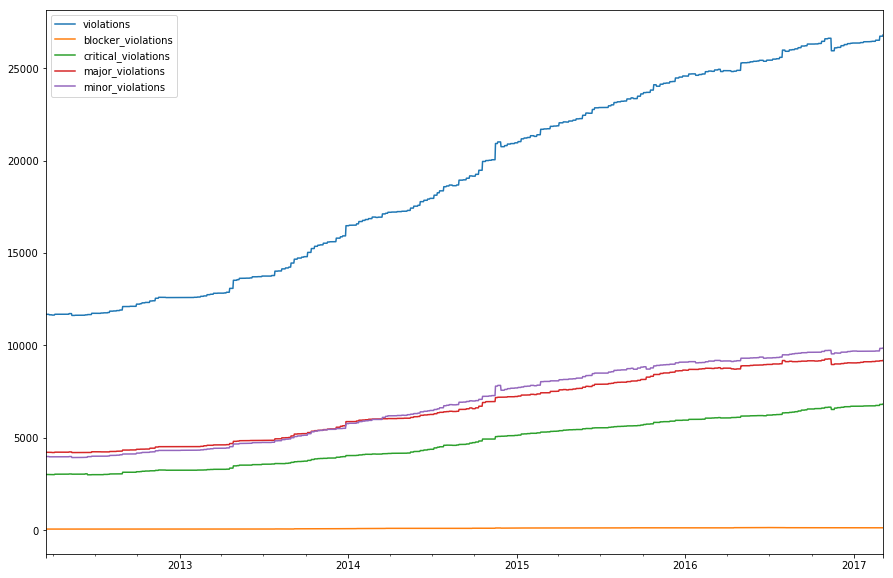

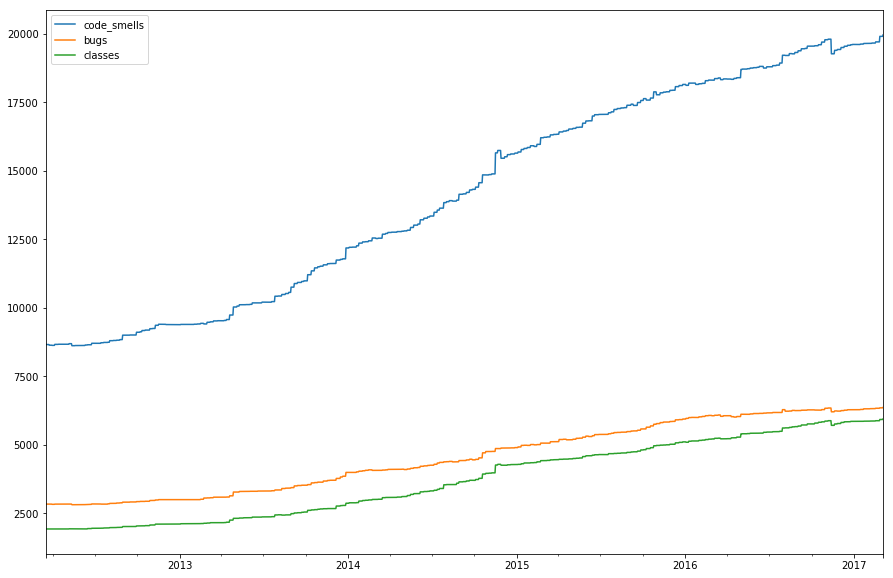

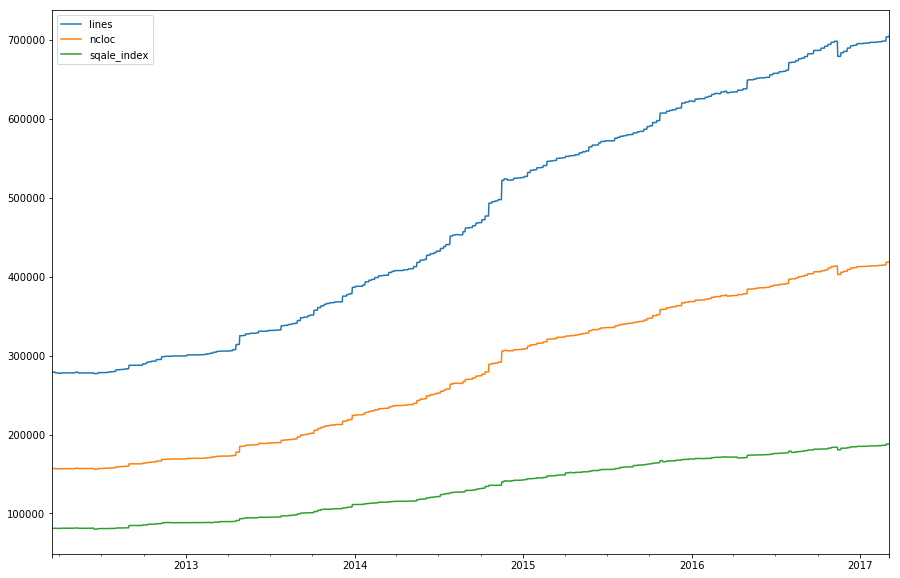

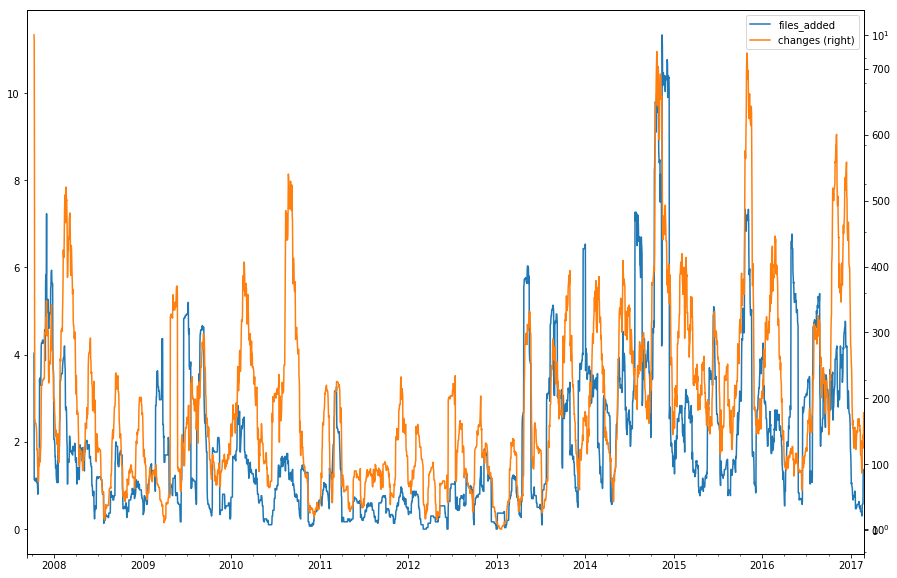

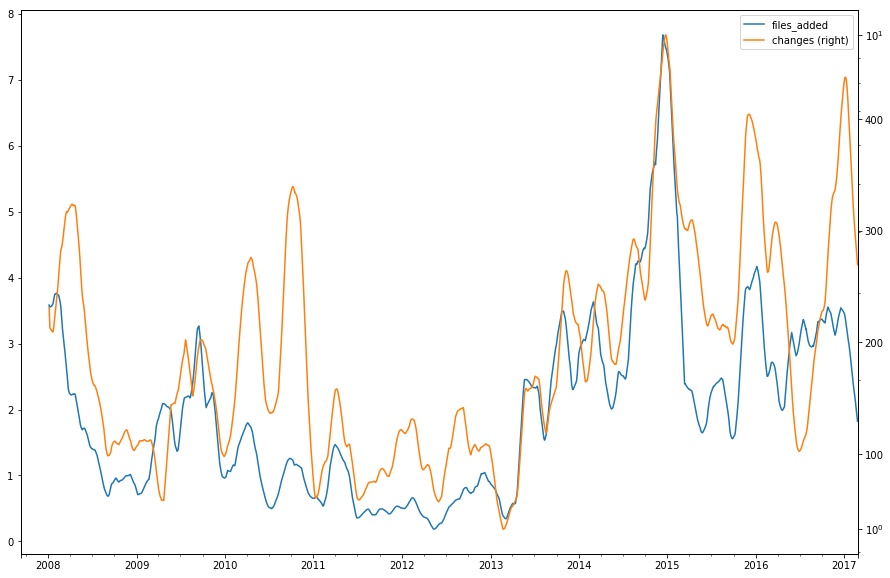

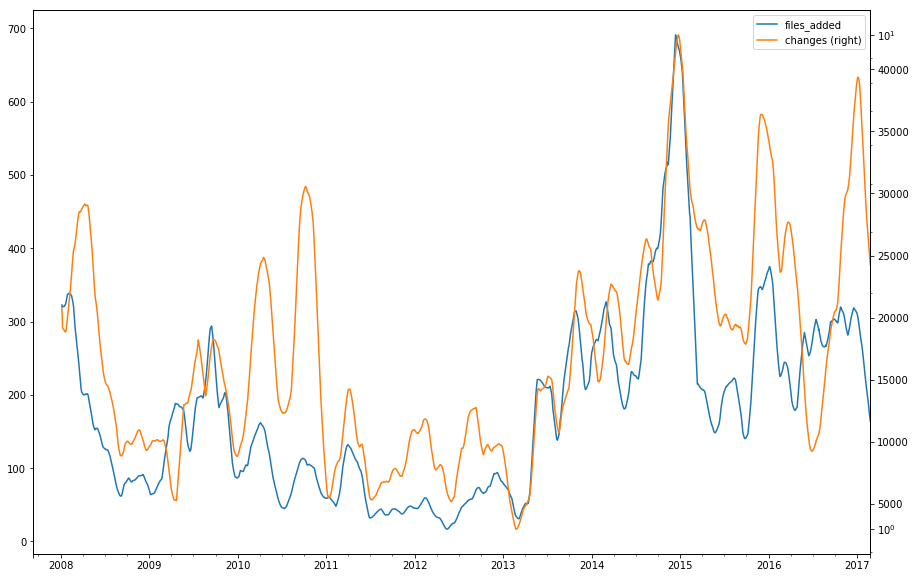

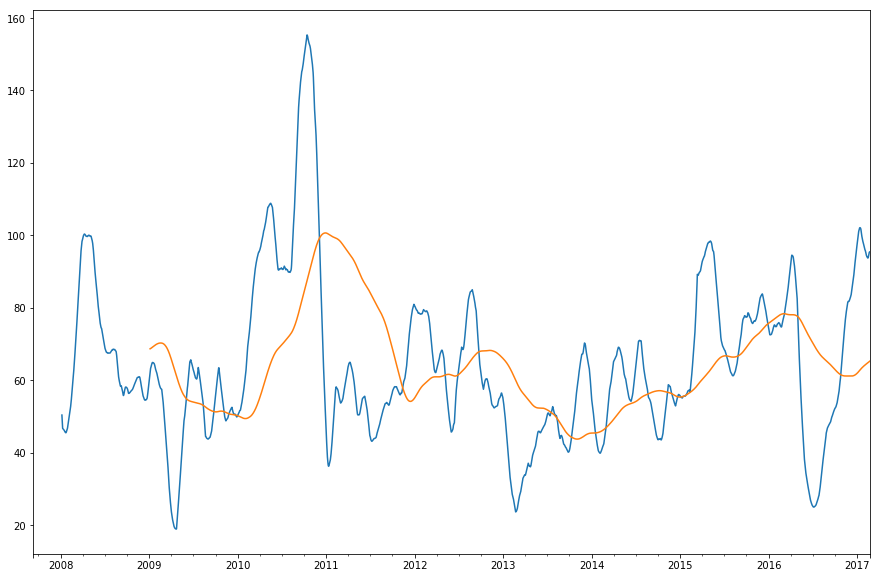

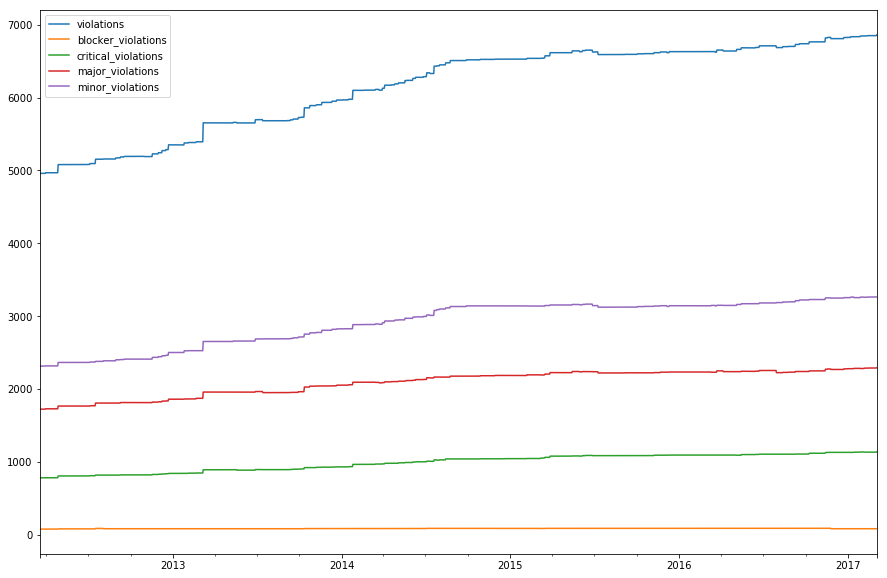

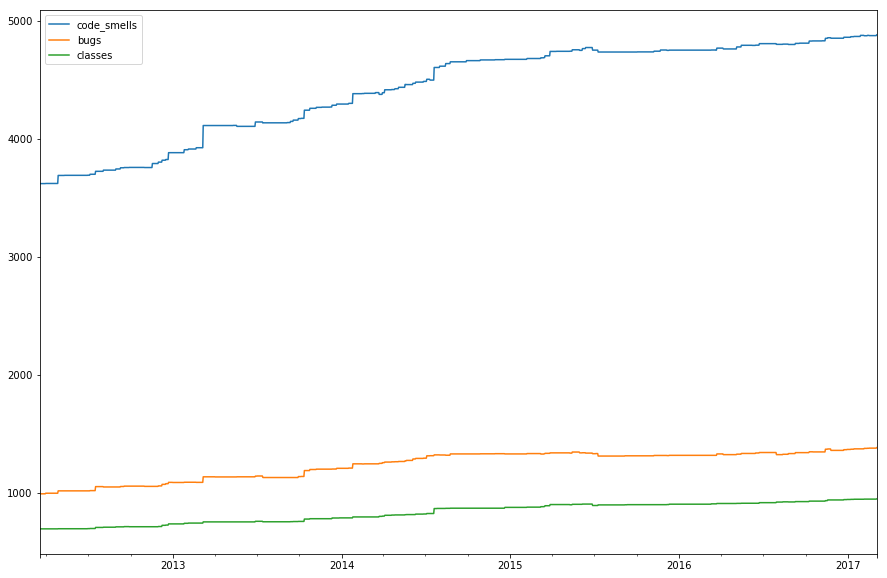

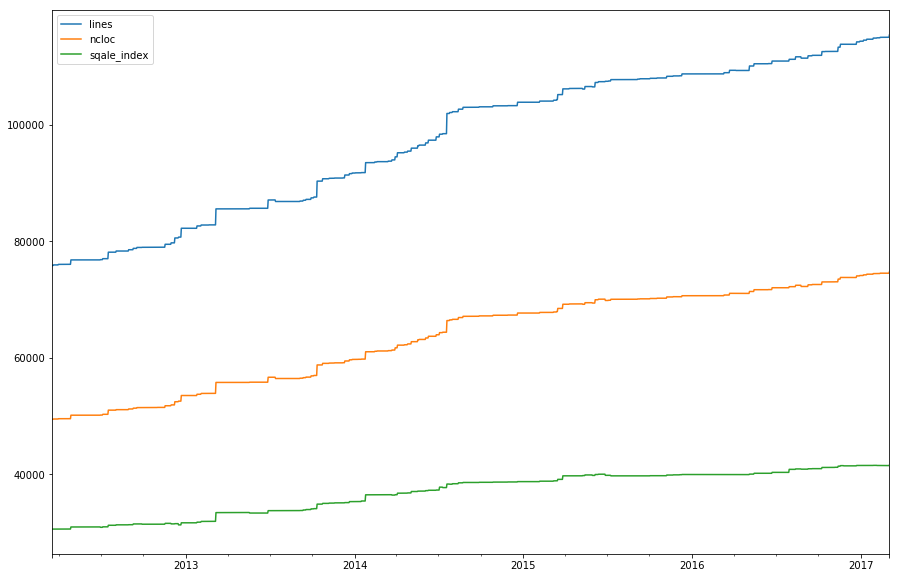

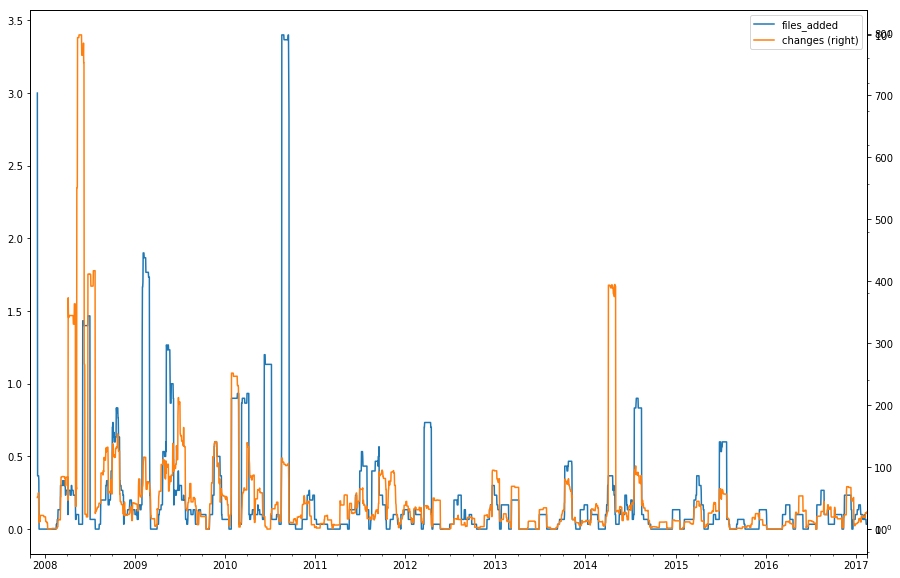

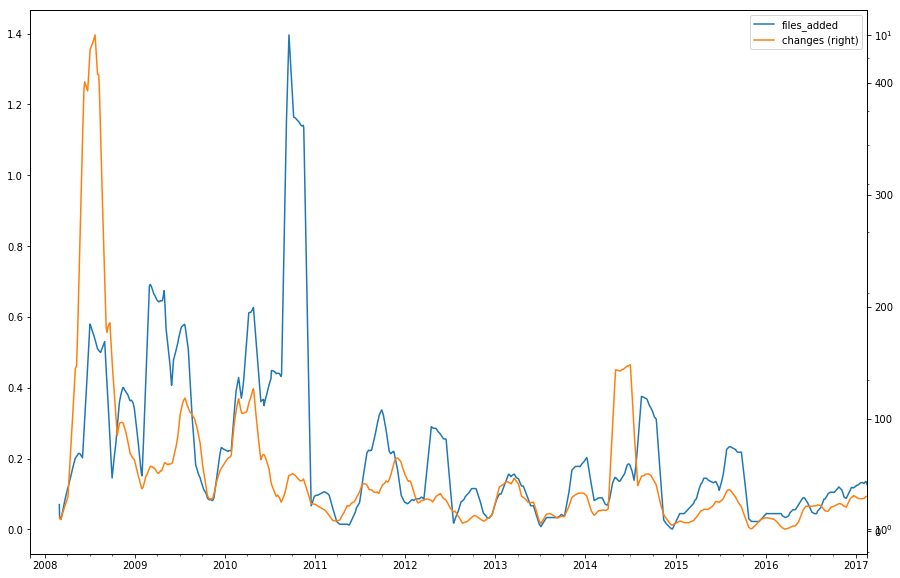

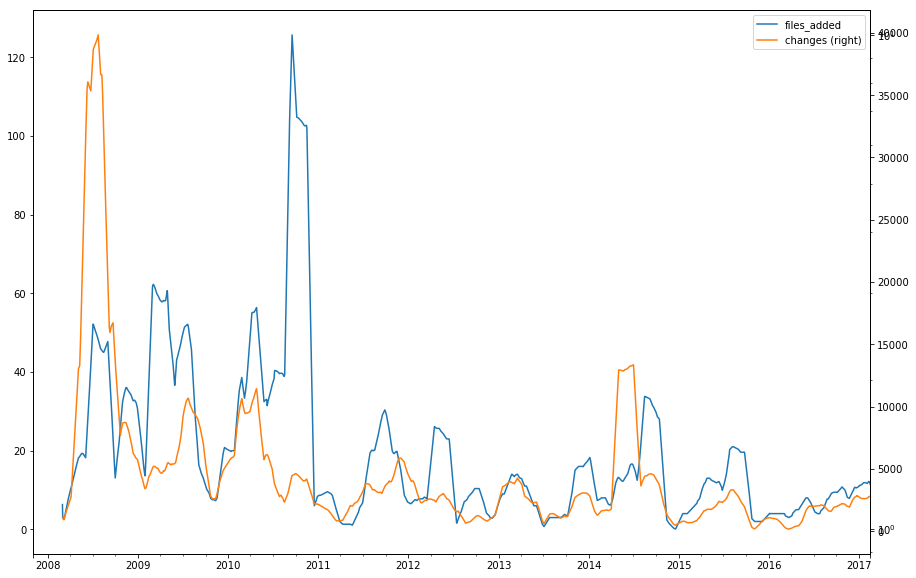

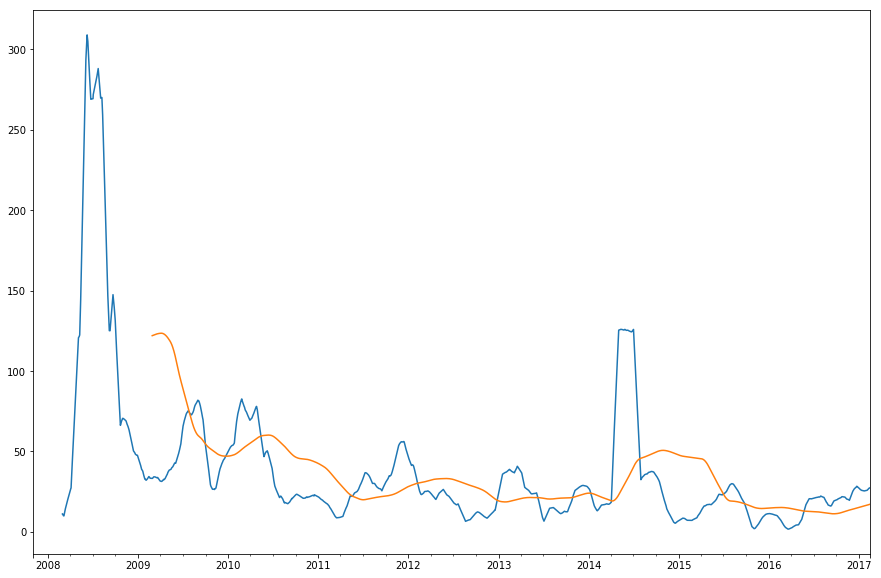

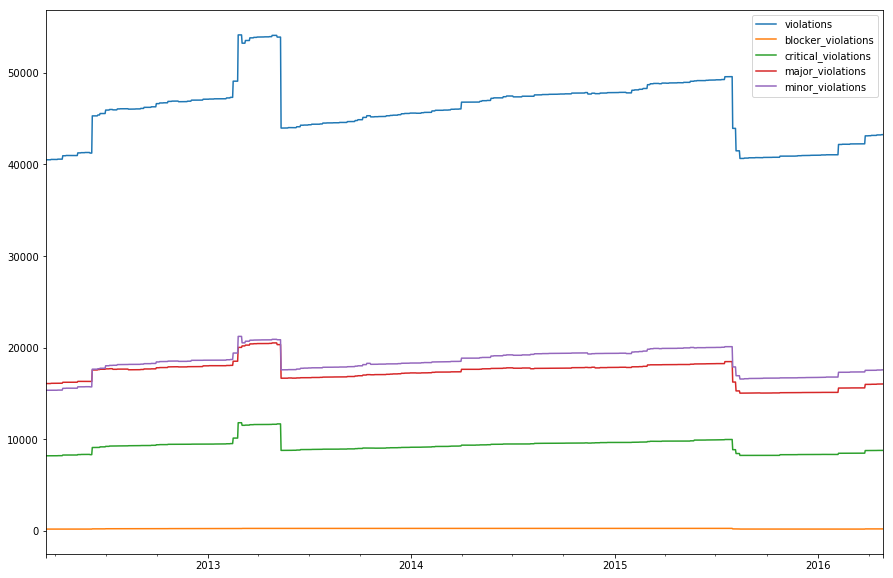

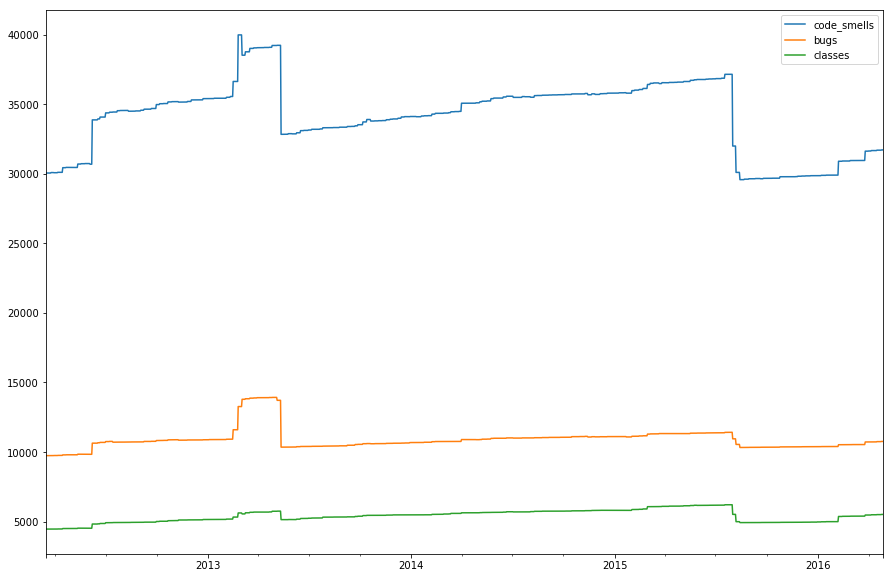

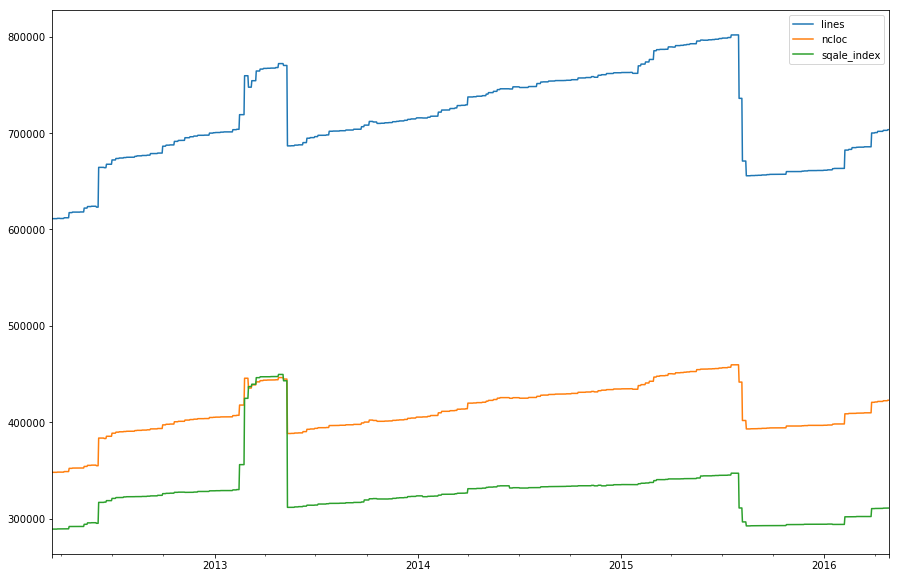

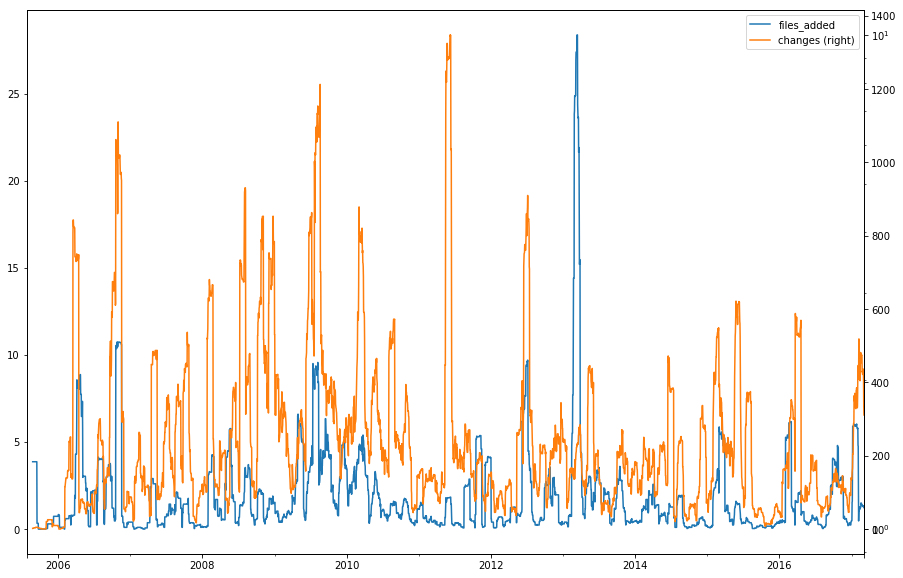

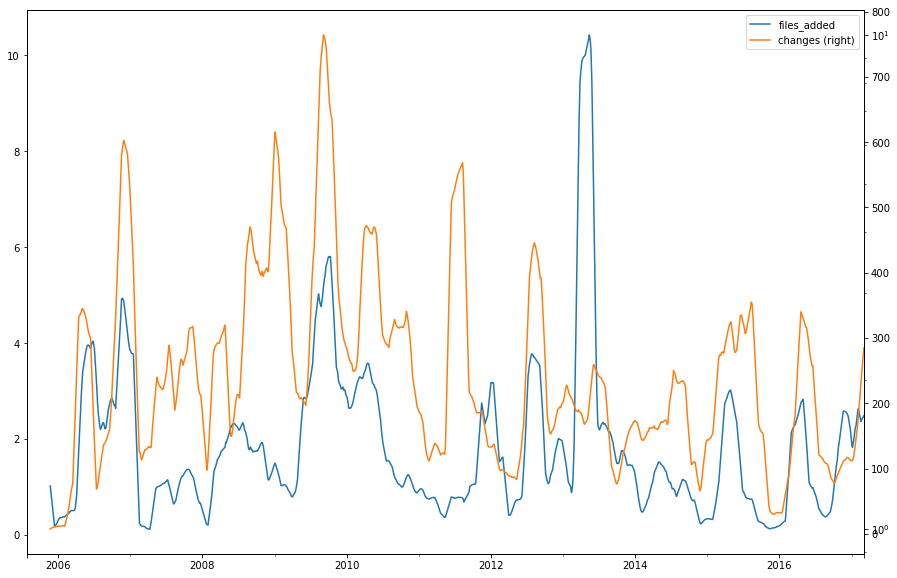

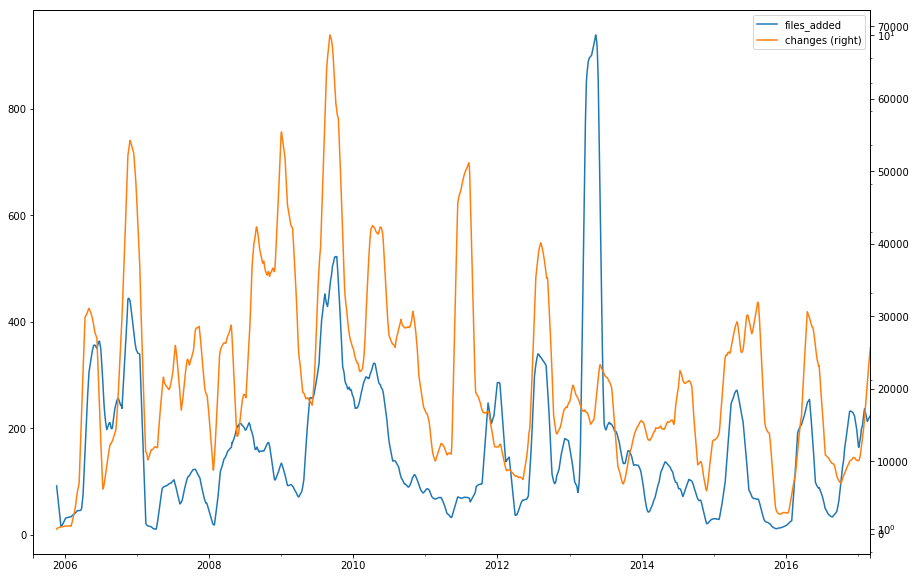

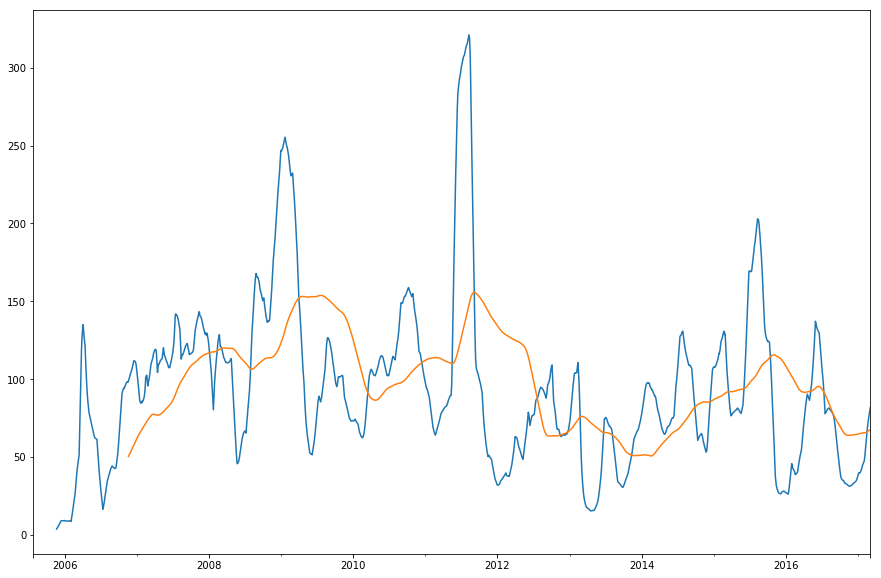

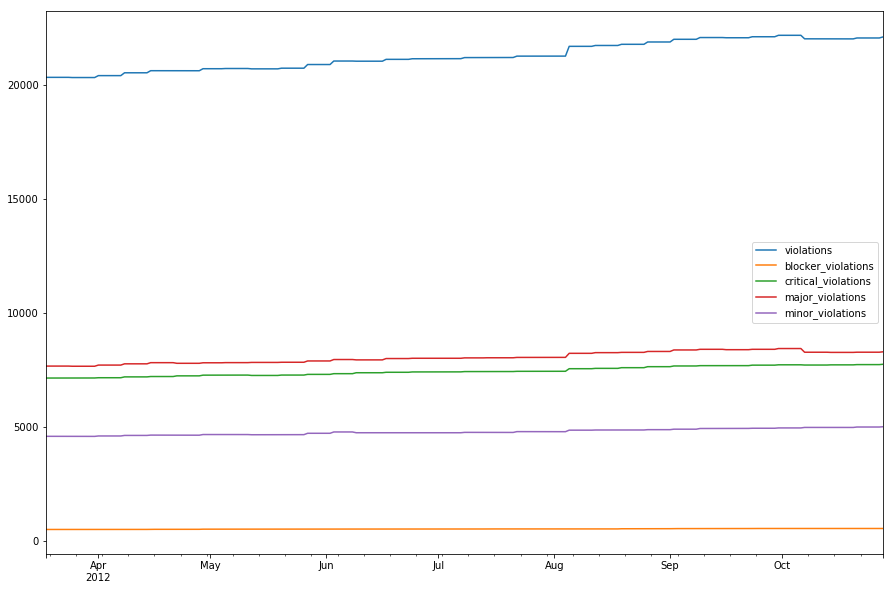

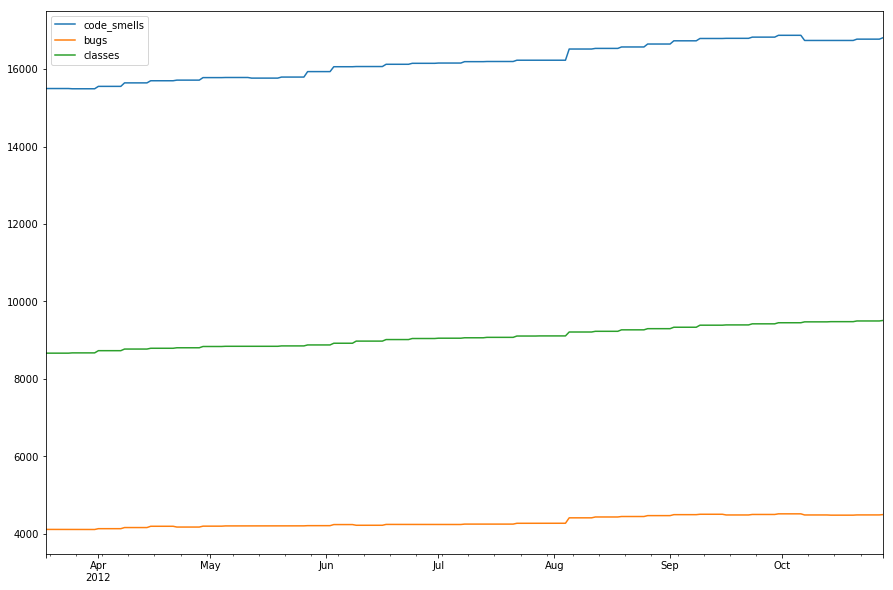

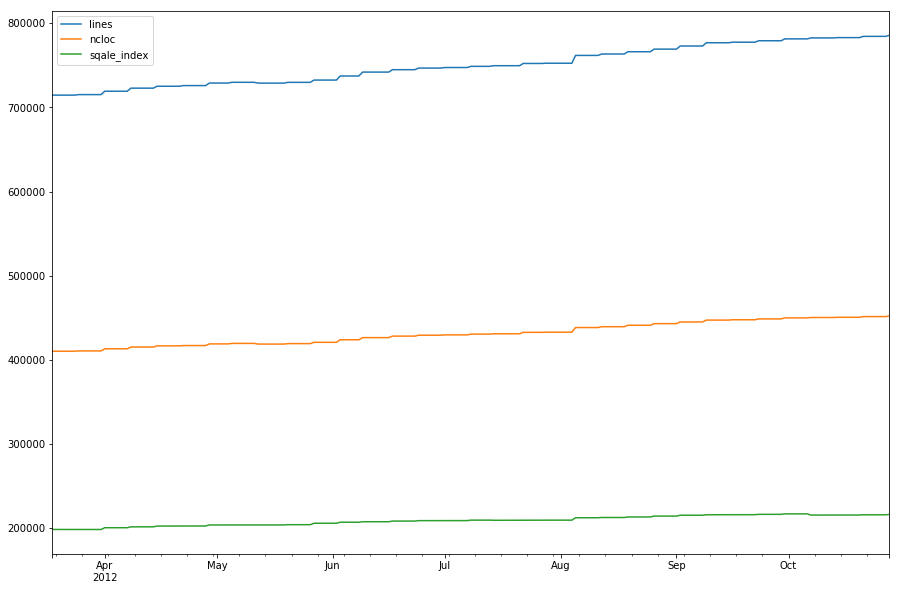

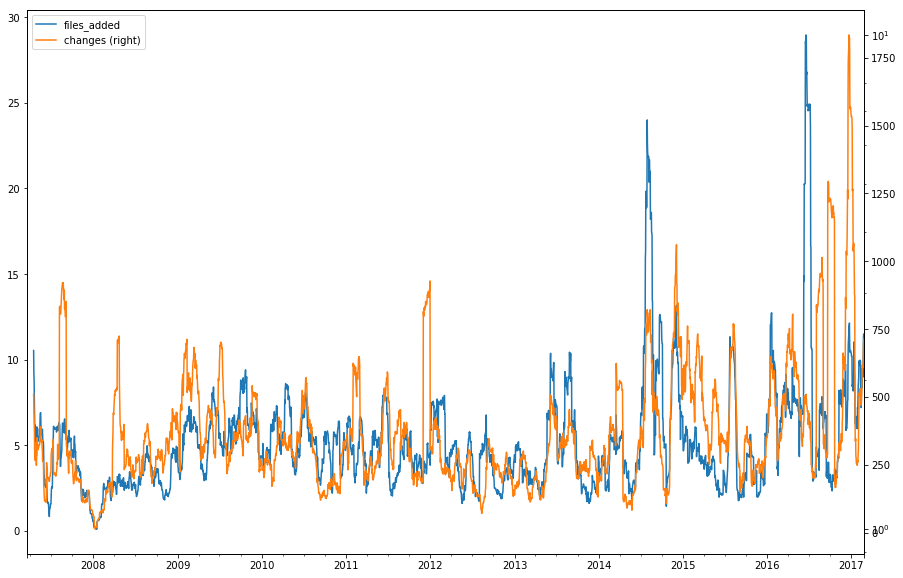

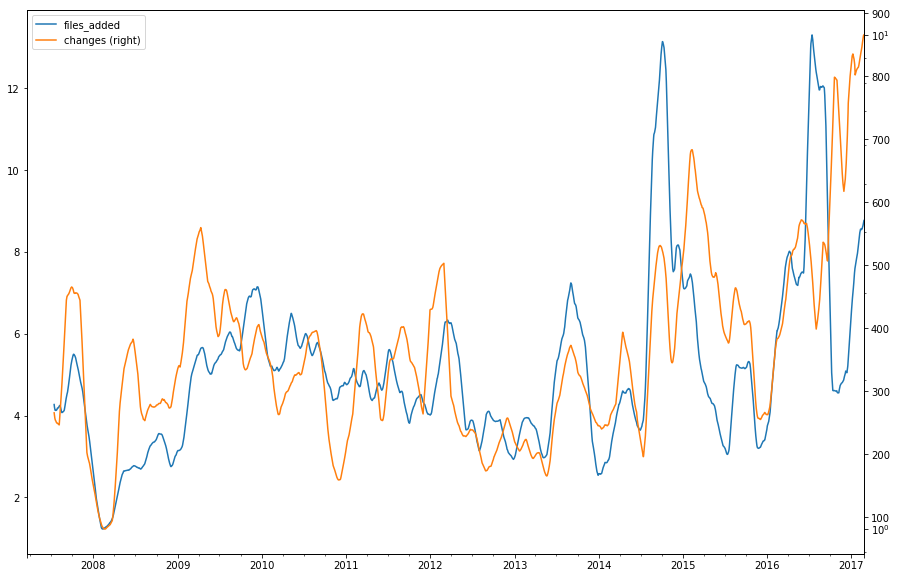

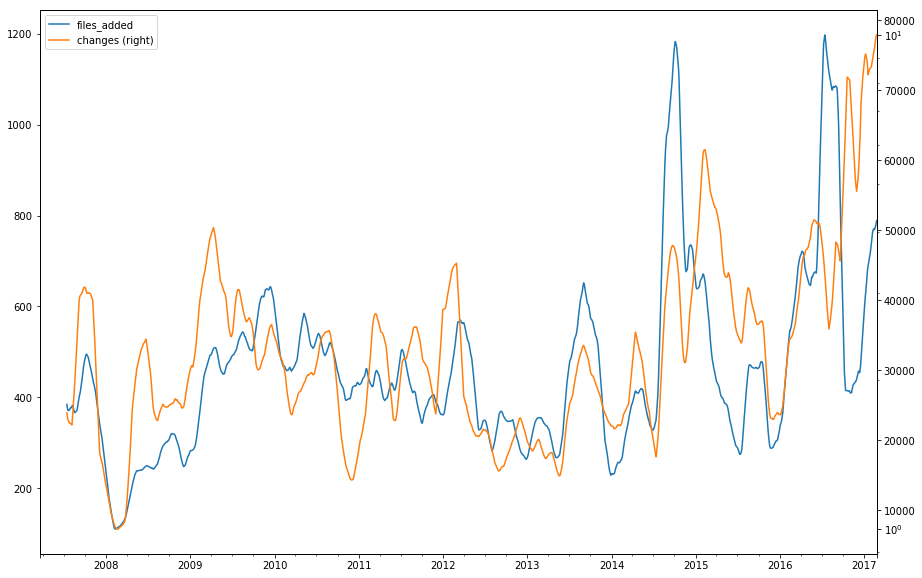

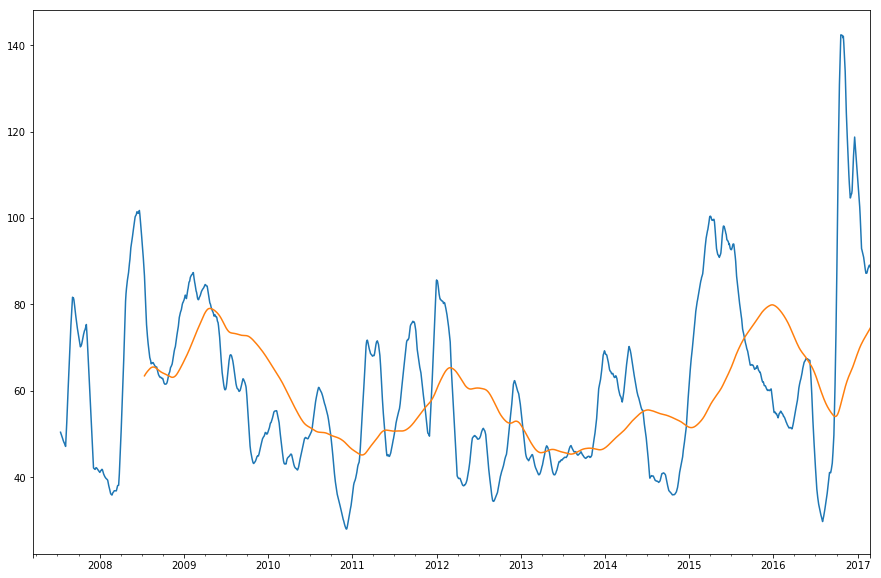

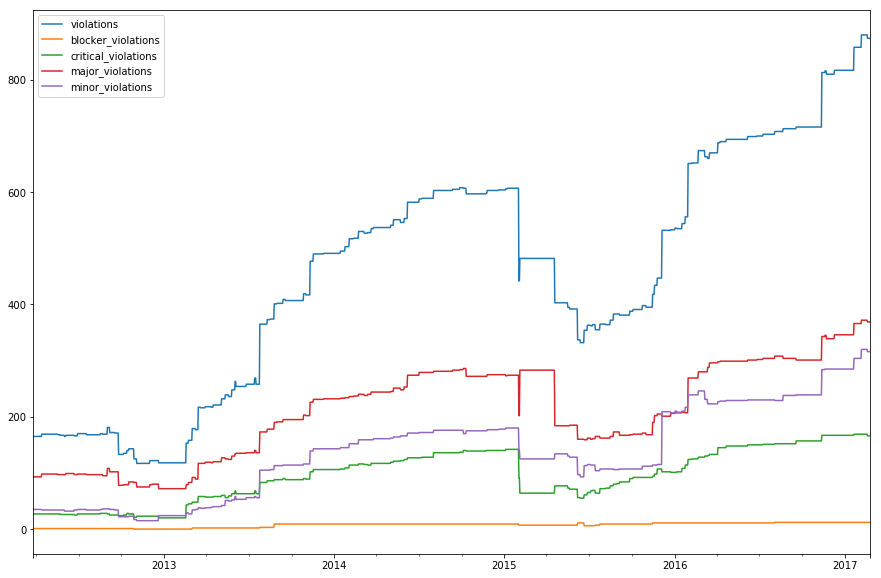

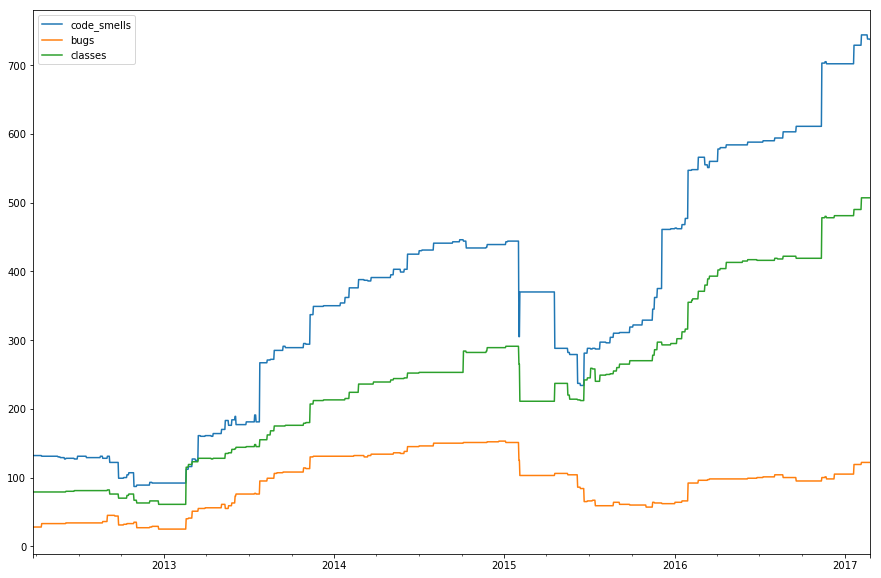

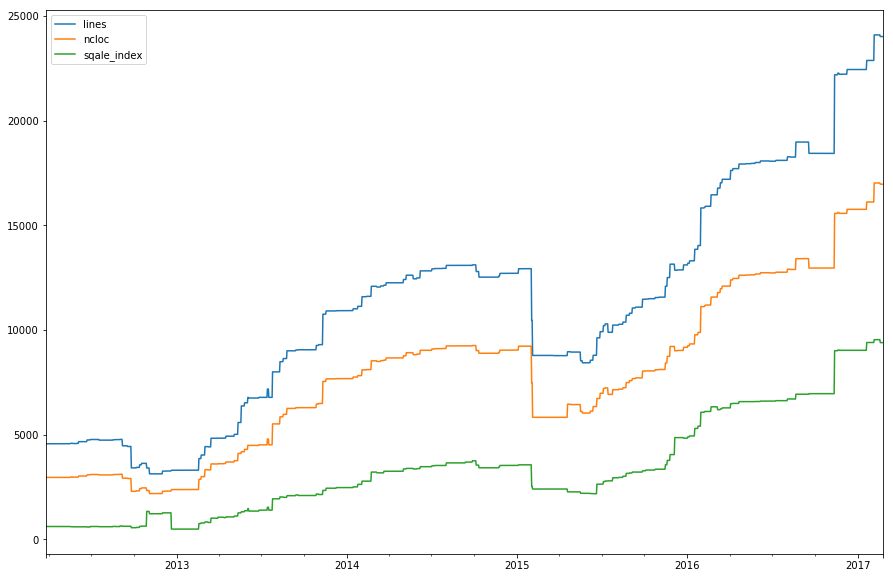

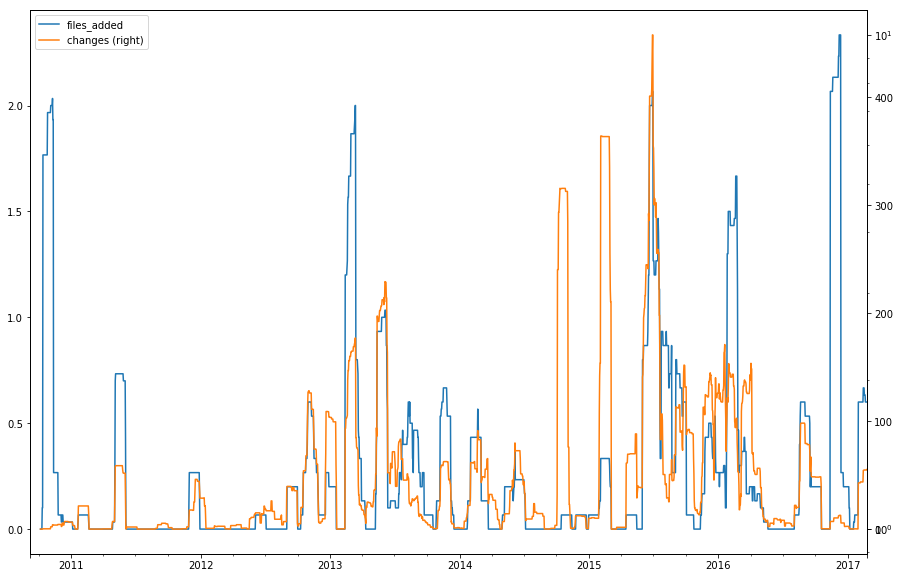

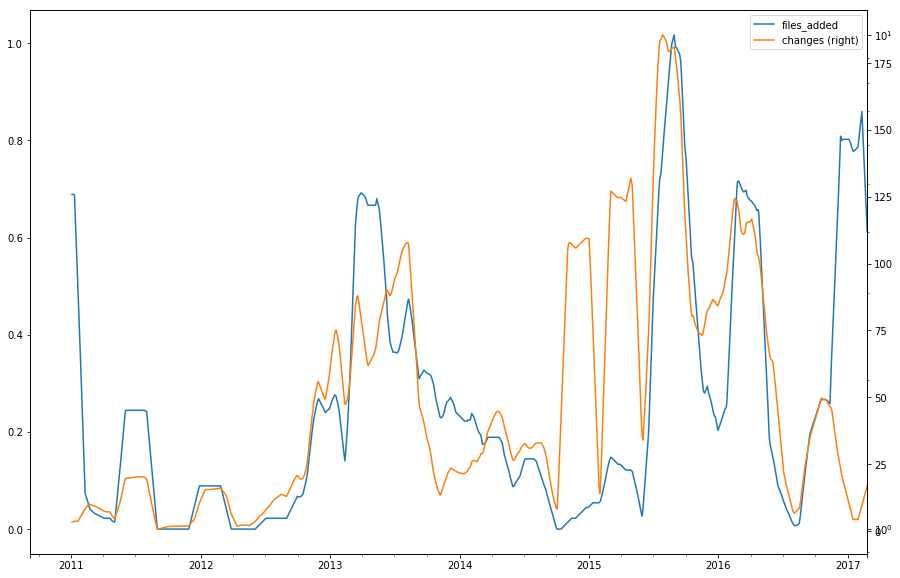

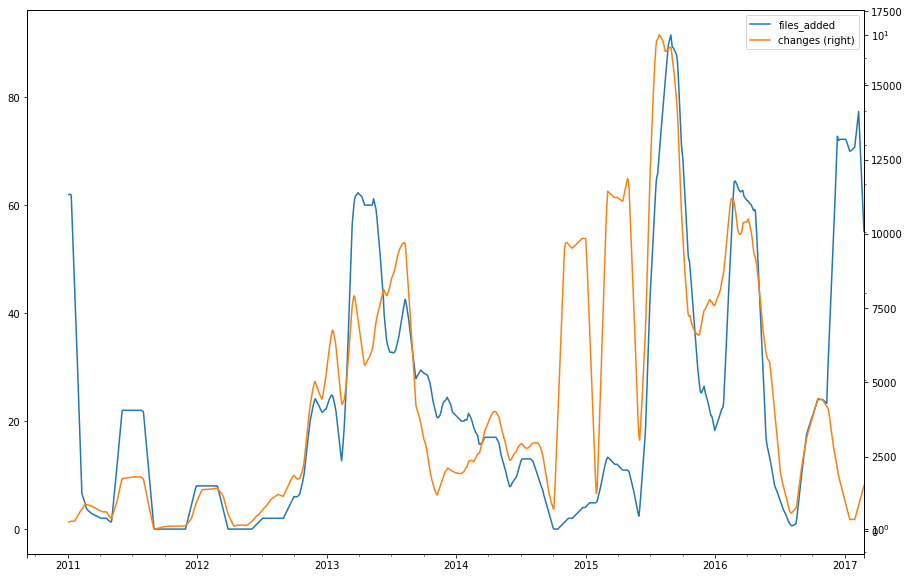

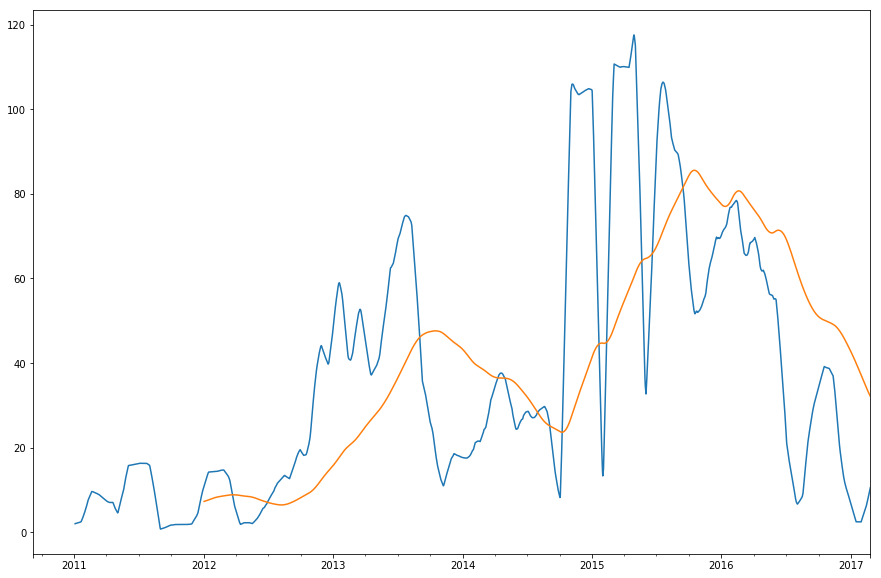

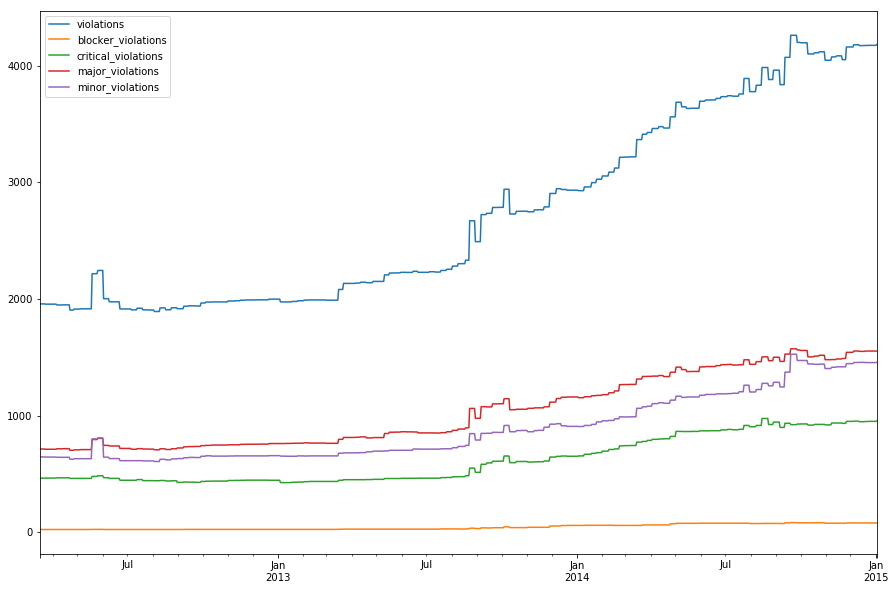

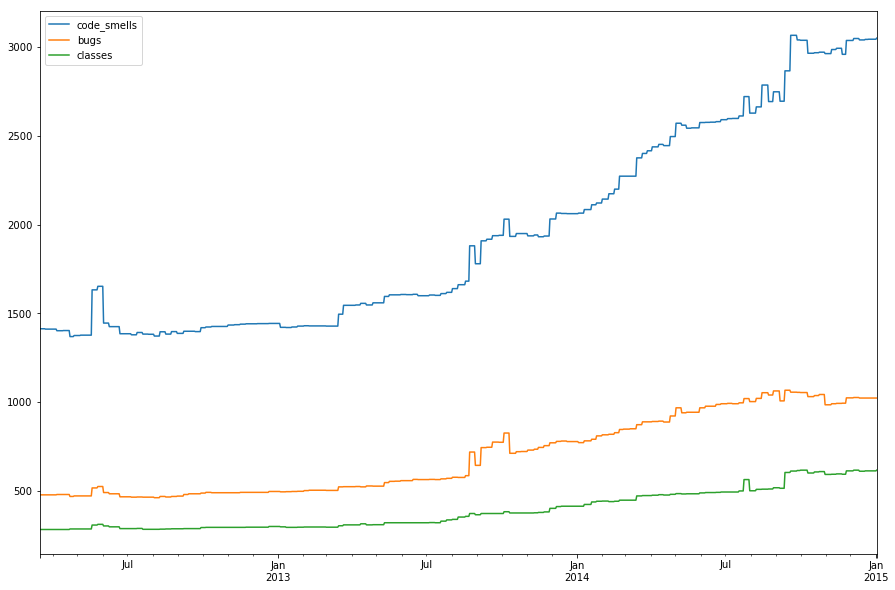

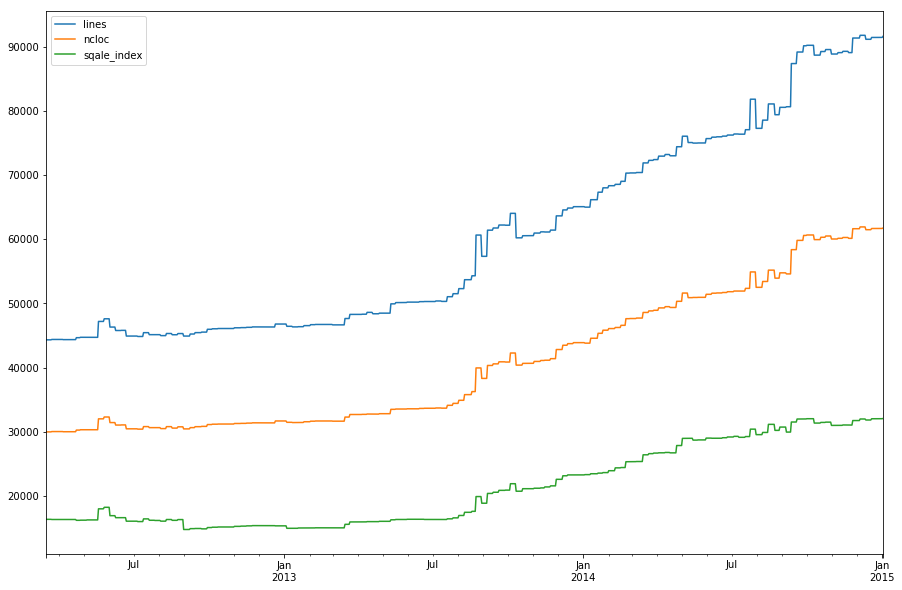

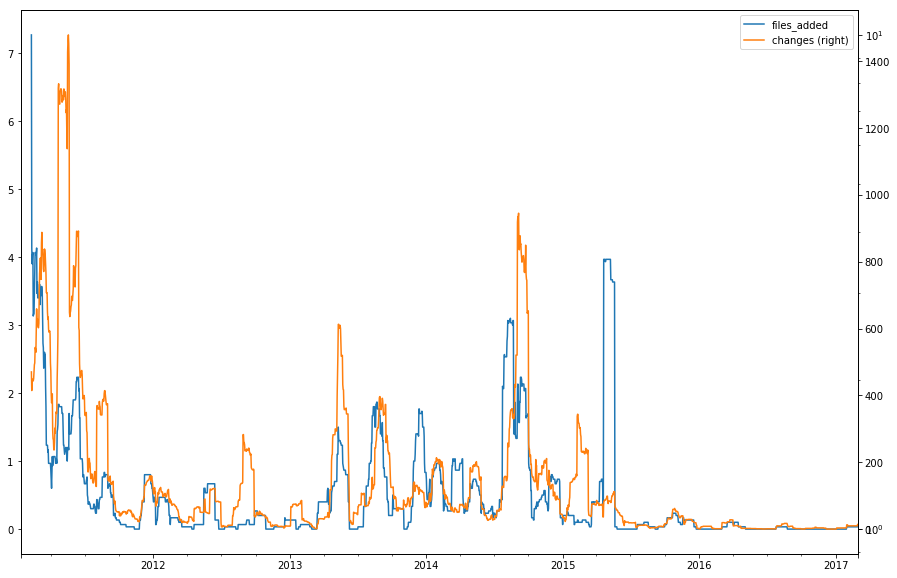

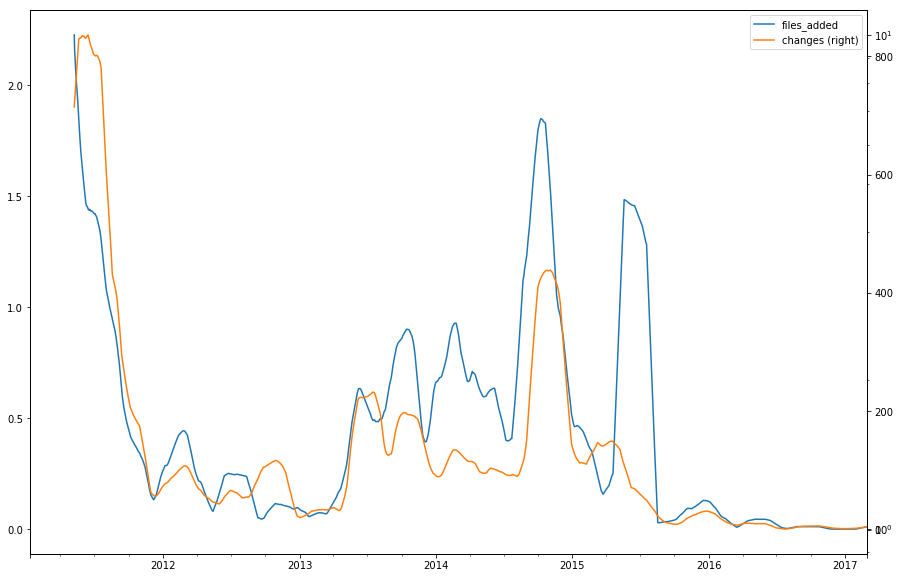

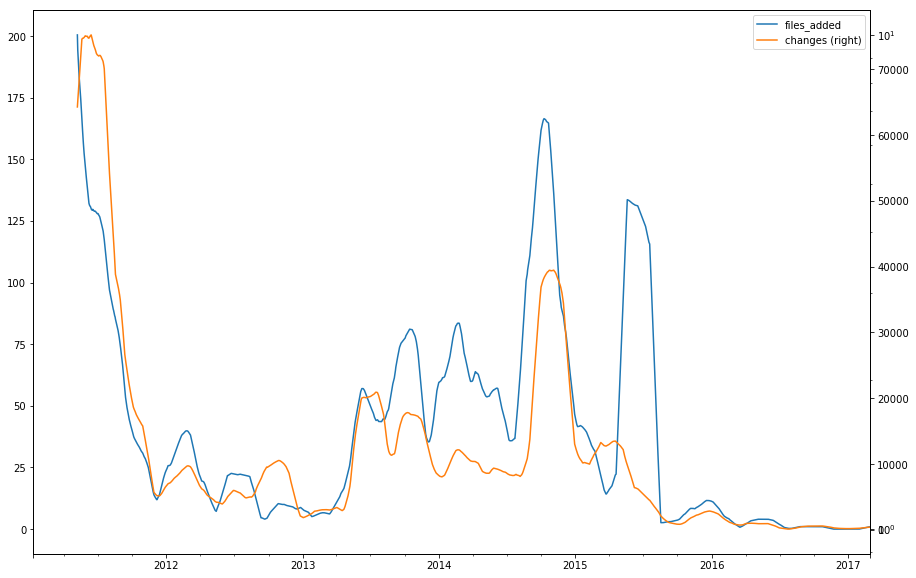

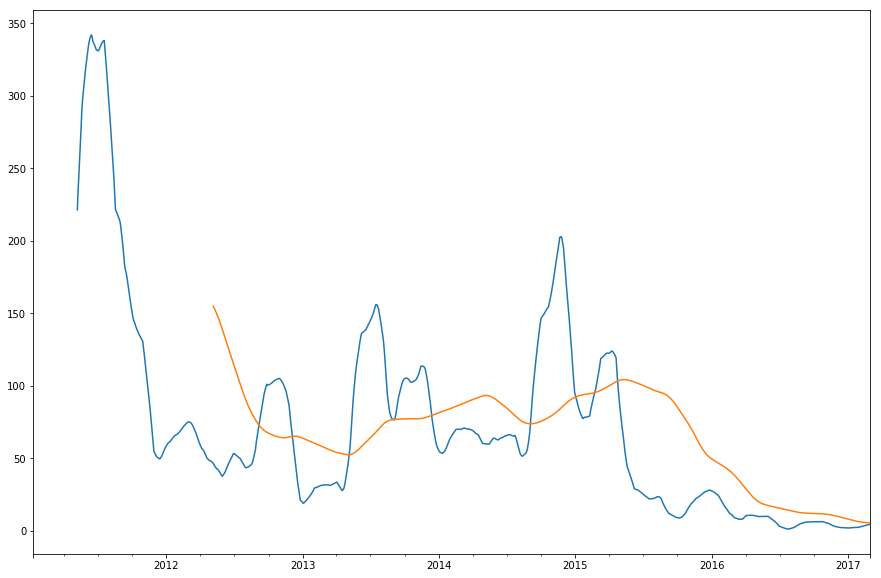

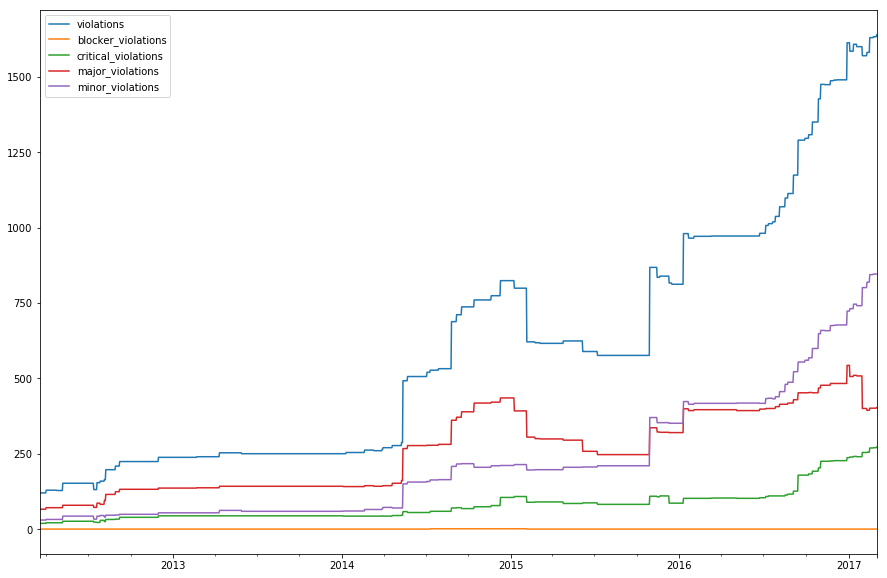

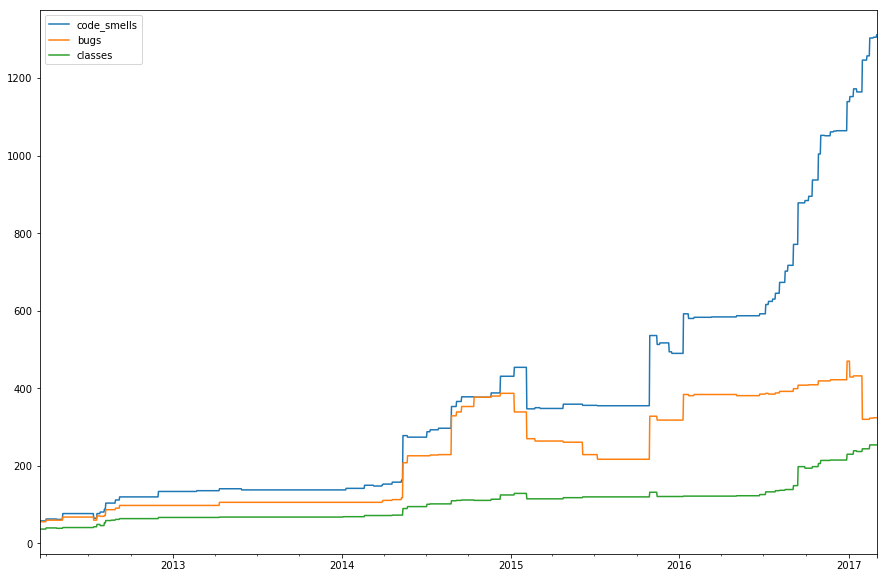

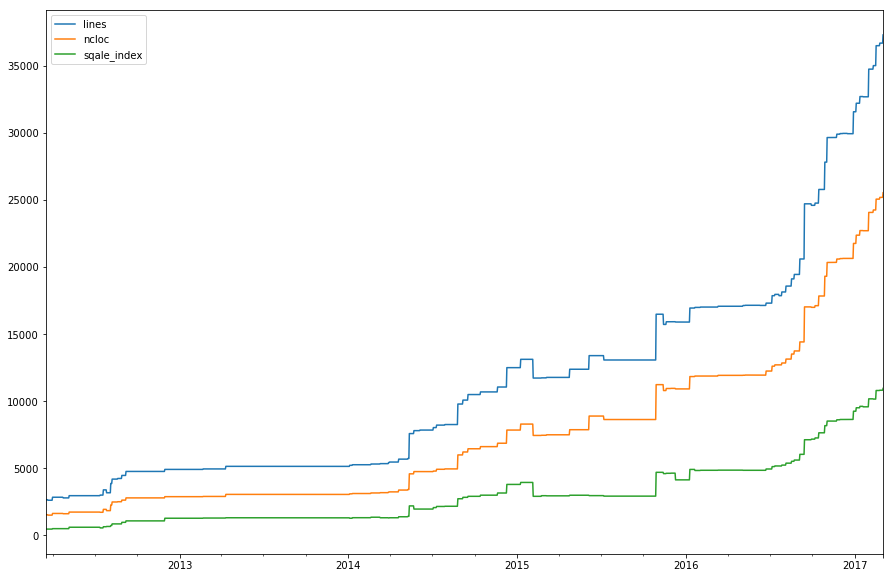

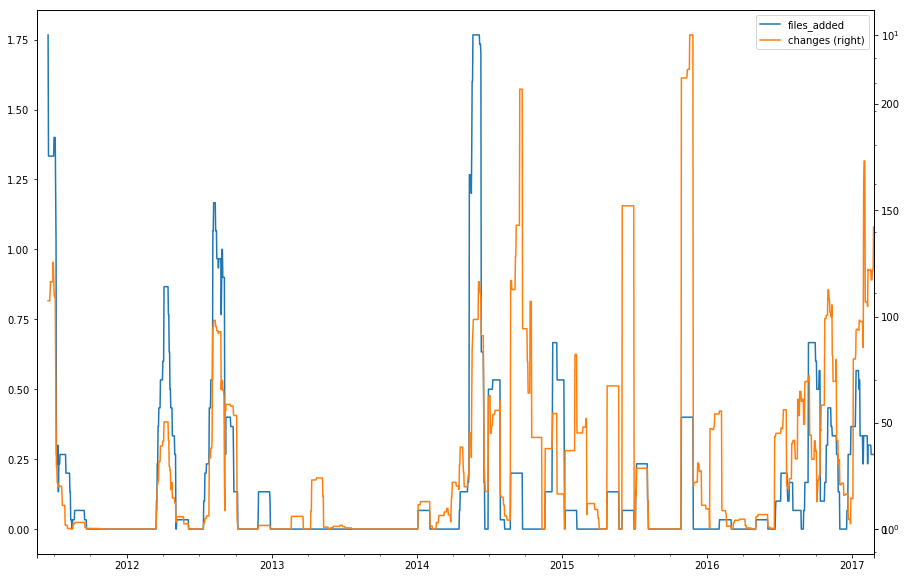

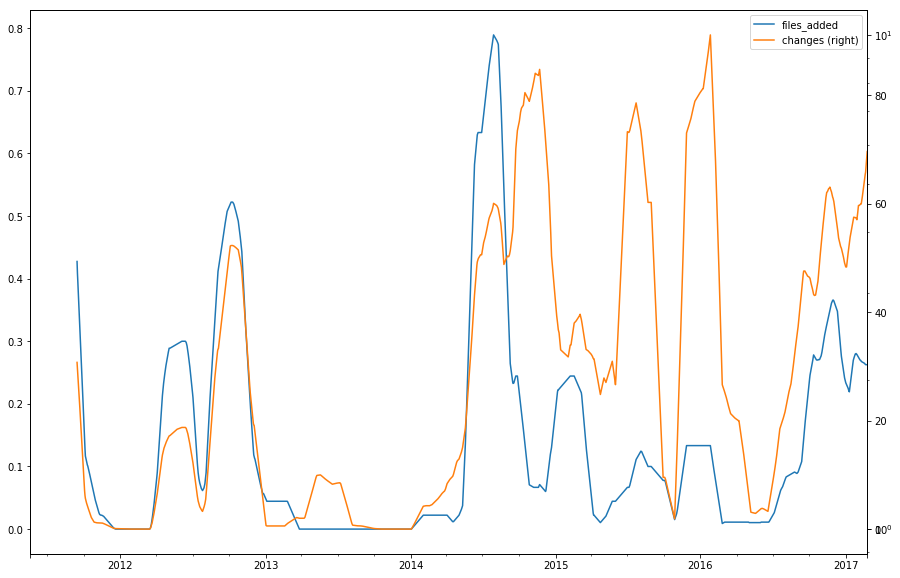

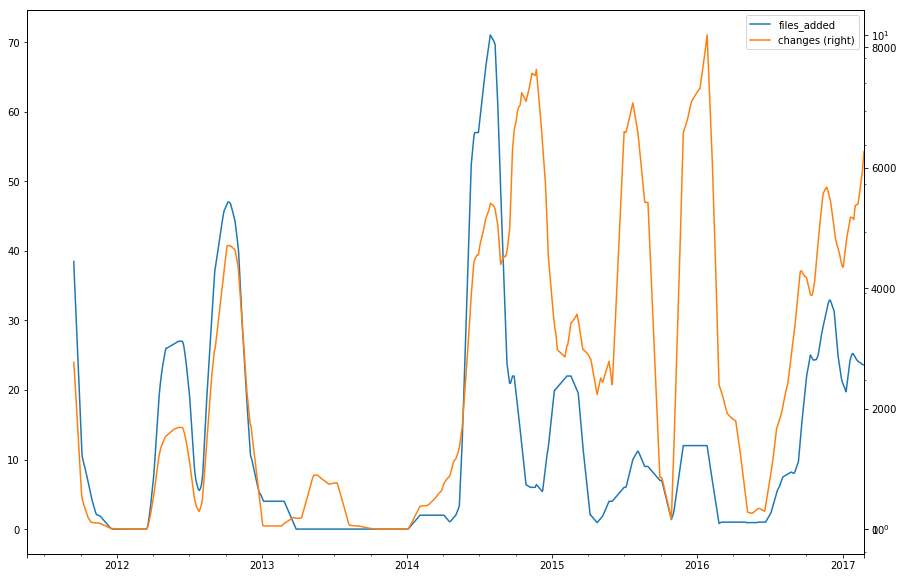

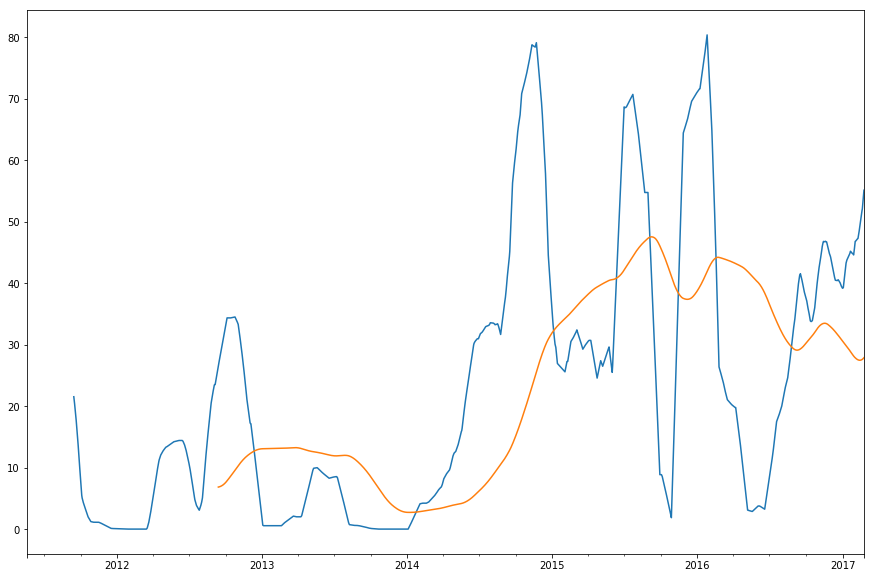

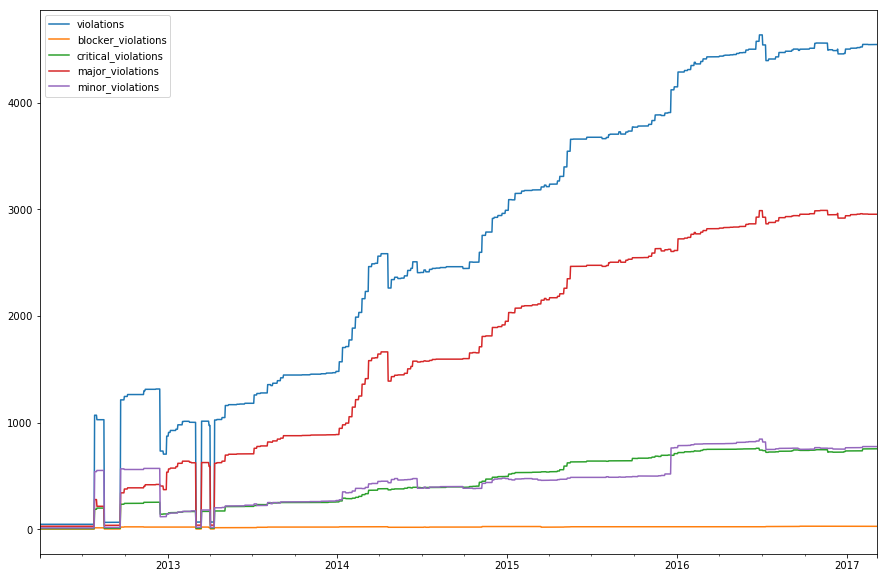

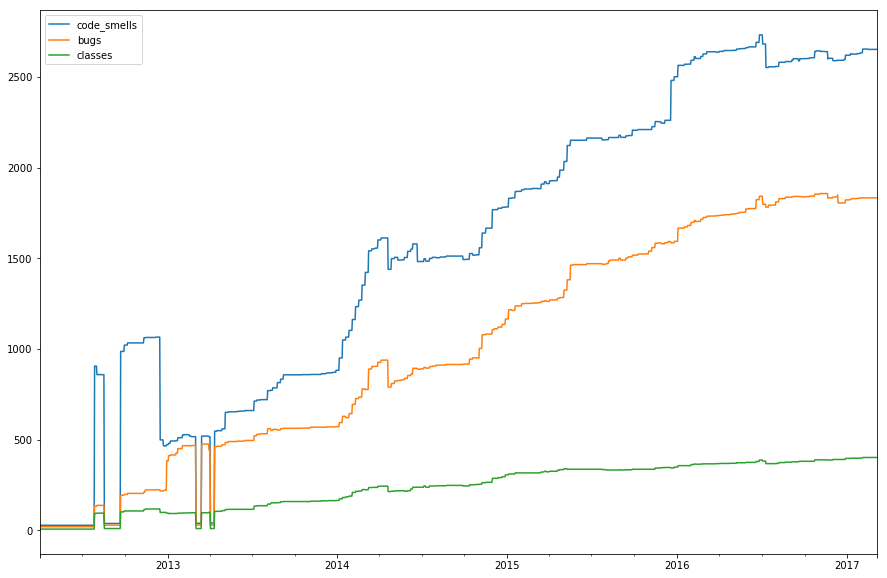

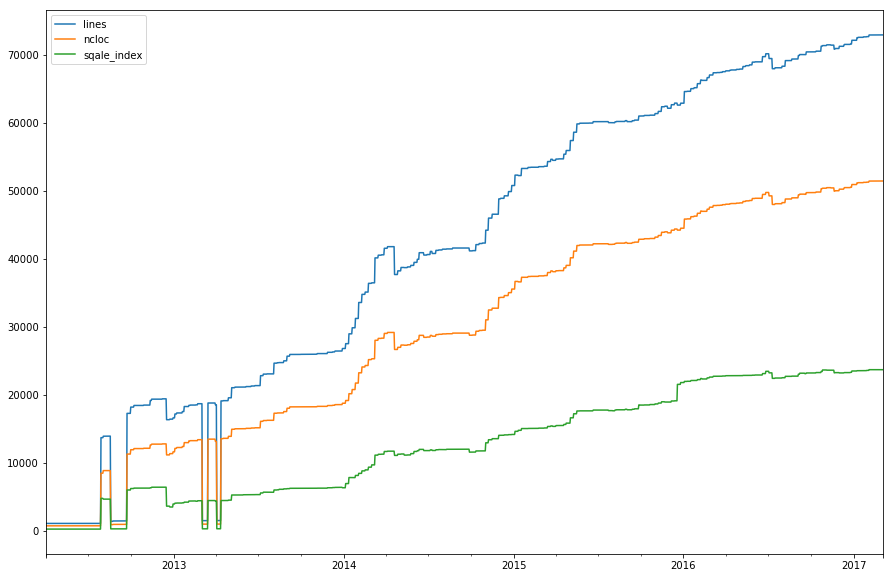

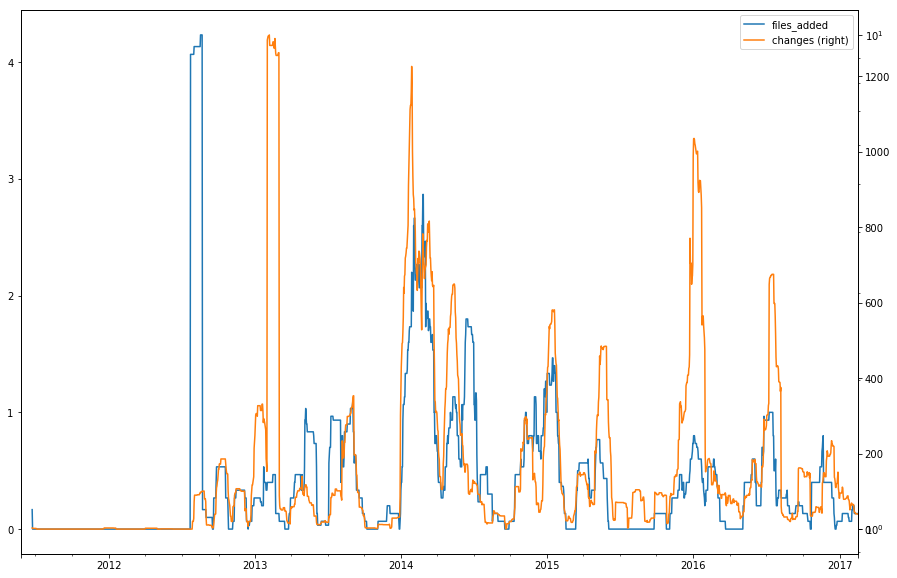

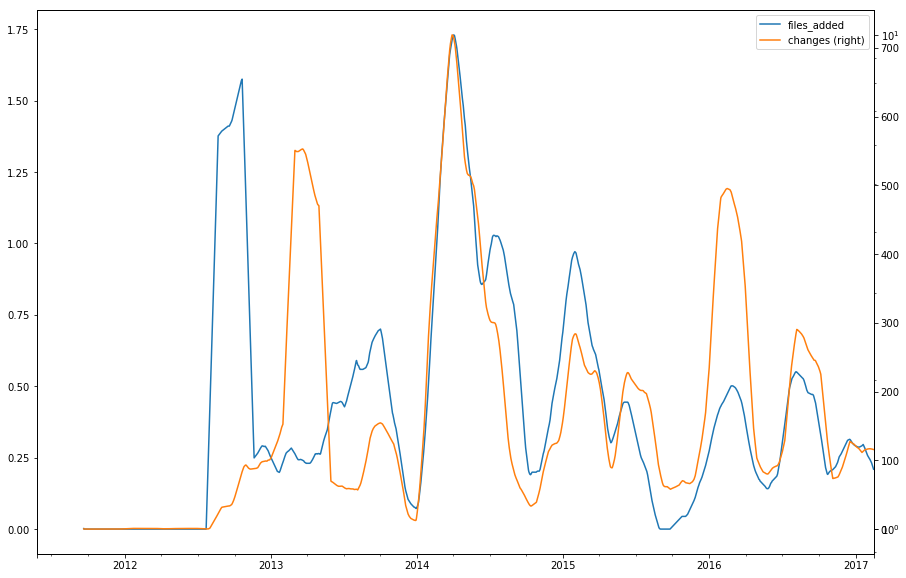

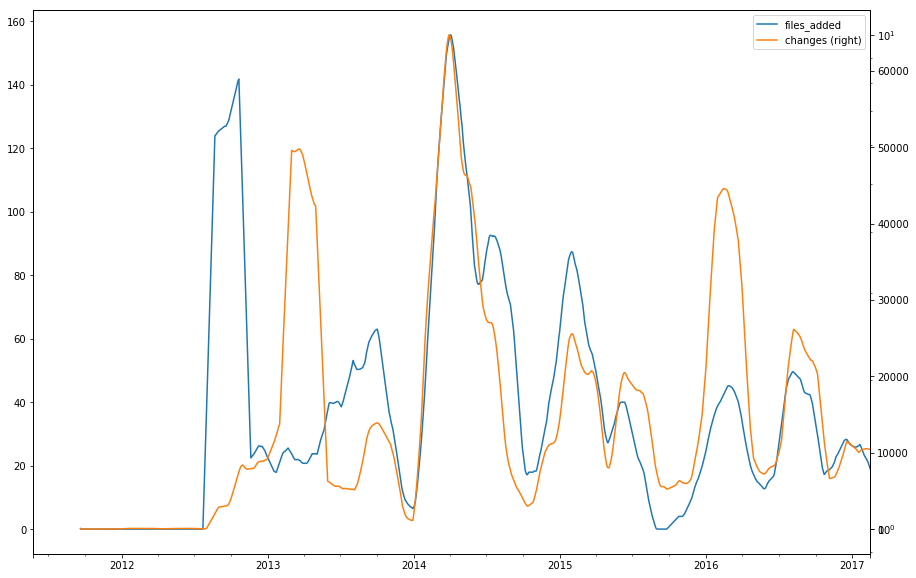

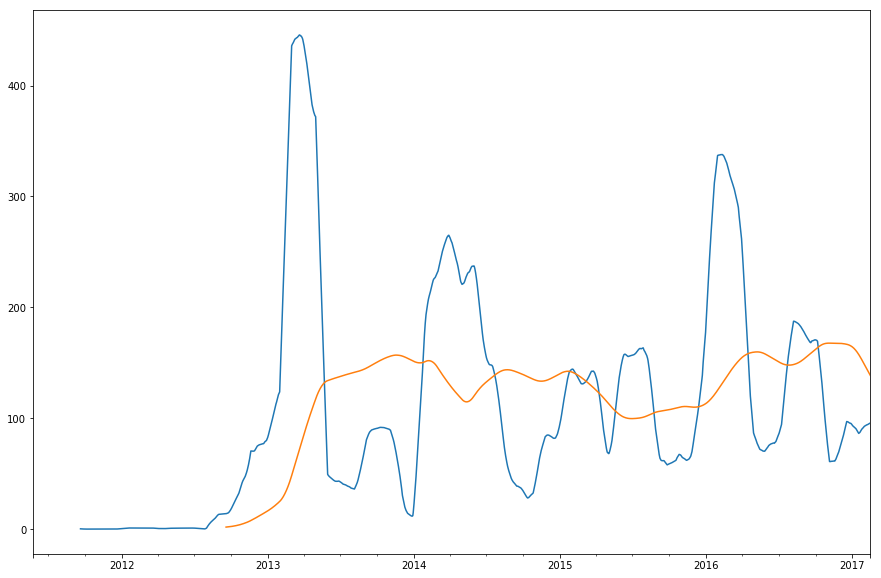

In [ ]:
repos = get_repos()
for ghp in repos:
    timemachine_metrics = get_sonarqube_timemachine_metrics_DataFrame(ghp)
    violations = timemachine_metrics[['violations','blocker_violations','critical_violations','major_violations','minor_violations']]
    smells_bugs_classes = timemachine_metrics[['code_smells','bugs','classes']]
    lines_sqale = timemachine_metrics[['lines','ncloc','sqale_index']]
    commitfiles_stats = get_commitfiles_stats_DataFrame(ghp)
    plot(violations.fillna(method='ffill'))
    plot(smells_bugs_classes.fillna(method='ffill'))
    plot(lines_sqale.fillna(method='ffill'))
    do_commit_analysis(commitfiles_stats)